# 1. Package Inport and AWS credentials

In [112]:

import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import seaborn as sns
import math
import os
import plotly.express as px
import geopy.distance
from scipy import stats
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 1. Functions


In [113]:
##===========================================================
## calculate if a day is clear-sky day
##===========================================================

def calculate_clearsky(df_site):
    df_site_clearsky = df_site.filter(like='EnergyYield.kWh.Daily')
    split_columns = df_site_clearsky.columns.str.split(':').str[1]
    df_site_clearsky.columns = split_columns
    df_site_clearsky.insert(0, 'date', df_site['date'].values)
    # df_site_clearsky = df_site_clearsky[(df_site_clearsky['date'] >= date_start) & (df_site_clearsky['date'] <= date_end)]

    # read the expected generation of different PV sites
    df_site_expected = df_site.filter(like='Irrad.kWh.m2.Daily')
    split_columns = df_site_expected.columns.str.split(':').str[1]
    df_site_expected.columns = split_columns
    df_site_expected.insert(0, 'date', df_site['date'].values)
    # df_site_expected = df_site_expected[(df_site_expected['date'] >= date_start) & (df_site_expected['date'] <= date_end)]

    # Calculate the cloudiness
    df_cloudiness = df_site_clearsky.copy()
    df_cloudiness.iloc[:, 1:] = df_site_expected.iloc[:, 1:]/df_site_clearsky.iloc[:, 1:]
    df_cloudiness.iloc[:, 1:] = df_cloudiness.iloc[:, 1:].astype(float)
    df_cloudiness.dropna(how='all', axis=1, inplace=True)
    df_cloudiness.iloc[:, 1:].fillna(axis=1, method='ffill', inplace=True)

    df_clearday_sites = df_cloudiness.copy()
    # Create a function to apply to each element in the DataFrame
    def set_to_true_or_nan(x):
        if pd.isna(x):
            return x
        return x > 0.8

    # Apply the function to the entire DataFrame
    df_clearday_sites.iloc[:, 1:] = df_clearday_sites.iloc[:, 1:].applymap(set_to_true_or_nan)
    return df_clearday_sites

In [114]:
##===========================================================
## calculate the distrances of the focus PV with other PVsites
##===========================================================
def Find_geodistance(focus_pvid, lat1, long1, df_table):
    pvlist = df_table['source'].values
    df = pd.DataFrame(index=np.arange(len(pvlist)), columns=['source'])
    df['source'] = pvlist
    distance_list = []
    coords_1 = (lat1, long1)
    for peerid in pvlist:
        lat2 = df_table[df_table['source']==peerid]['latitude'].values[0]
        long2 = df_table[df_table['source']==peerid]['longitude'].values[0]
        coords_2 = (lat2, long2)
        # print('coords:', coords_1, coords_2)
        geodis = geopy.distance.geodesic(coords_1, coords_2).km
        distance_list.append(geodis)
    df['distance(km)'] = np.array(distance_list)
    df.sort_values(by=['distance(km)'], inplace=True)
    focus_index = df[(df.source == focus_pvid)].index
    df.drop(focus_index, inplace=True)
    return df

In [115]:
# ==============================================================
# = read table and find latitude/longitude of PV sites
# ==============================================================
def Read_tables_distance(df_sites):
    # pv site table
    # df_att['timezone'] = df_att['siteId'].map(df_tz.set_index('source')['timezone'])
    df_sites = pd.read_csv('../input_data/SITE_nodeType_20230630.csv', header=0)
    print('Total_number of PV sites: ', len(df_sites))

    # we find that some sites that have no latitude in Site table might have latitude/longitud attributes in monitor table
    df_attribute = pd.read_csv('../input_data/MNTR_ddb_20230630.csv')
    df_attribute.drop_duplicates(subset='siteId', inplace=True)
    df_sites['latitude1'] = df_sites['source'].map(df_attribute.set_index('siteId')['latitude'])
    df_sites['longitude1'] = df_sites['source'].map(df_attribute.set_index('siteId')['longitude'])
    df_sites.loc[df_sites['latitude'].isnull(),'latitude'] = df_sites['latitude1']
    df_sites.loc[df_sites['longitude'].isnull(),'longitude'] = df_sites['longitude1']
    df_sites.drop(['latitude1', 'longitude1'], axis=1, inplace=True)
    print('Number of PV site without latitude-longitude attribute: ', len(df_sites[df_sites['latitude'].isnull()]))

    df_sites.dropna(subset=['latitude'], inplace=True)
    df_sites['latitude'] = [x[1:] for x in df_sites['latitude']]
    print('Number of PV sites with location information: ', len(df_sites))
    return df_sites

In [116]:
# ==============================================================
# = read/calculate peer number and distances of PV sites
# ==============================================================
def Cacluate_Read_Peer_Distance(file_path, df_sites):
    if os.path.exists(file_path):
        print('Read from the existing file: ', file_path)
        df_distance = pd.read_csv(file_path, header=0)
    else:
        print('Calculate Peer number and distance, it might take about 4 minutes')
        pvnumber_for_distance = 50
        max_distance_list = [1, 3, 5, 10, 15] # km
        pvsites_list = df_sites['source'].values
        cols = ['peernumber({}km)'.format(p) for p in max_distance_list]
        cols_list = ['Top{}||(km)'.format(i) for i in range(pvnumber_for_distance)]
        df_distance = pd.DataFrame(index=range(len(pvsites_list)), columns=['source'] + cols + cols_list )
        df_distance['source'] = pvsites_list

        for i, site_id in enumerate(pvsites_list):
            latitude_focus_site = df_sites[df_sites['source']==site_id]['latitude'].values[0]
            longitude_focus_site = df_sites[df_sites['source']==site_id]['longitude'].values[0]
            df_sort_site_distance = Find_geodistance(focus_pvid=site_id, lat1=latitude_focus_site, long1=longitude_focus_site, df_table=df_sites)
            df_sort_site_distance['col_values'] = df_sort_site_distance['source'] + '||' + df_sort_site_distance['distance(km)'].round(2).astype(str)
            df_distance.iloc[i, len(max_distance_list)+1:] = df_sort_site_distance['col_values'].values[0:pvnumber_for_distance]
            for d, dis in enumerate(max_distance_list):
                df_distance.iloc[i, d+1] = len(df_sort_site_distance[df_sort_site_distance['distance(km)'] <= dis])
        df_distance.to_csv('../preprocessed_data/PVsite_distance_Peers.csv', index=None)
        df_distance.iloc[:, 0:4].to_csv('../preprocessed_data/PVsite_PeerNum.csv', index=None)
        
    return df_distance

In [117]:
font = {'family': 'Times New Roman',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }
matplotlib.rcParams['font.sans-serif'] = ['Times New Roman']
matplotlib.rc('xtick', labelsize=16)
matplotlib.rc('ytick', labelsize=16)
plt.rcParams['savefig.dpi'] = 60

# 2. Parameter Settings

Notes on timestream:

Irrad.kWh.m2.Daily - Expected Generation

EnergyYield.kWh.Daily - Clear Sky Model

Production.kWh.Daily - Measured Generation

Performance = Measured / Expected * 100

In [118]:
# Good example of site with a lot of above 100% performance:
# site_id = "b0ccb4b2-aa32-4b12-8c78-76d42b450f70"

# site_id = 491cceae-2d72-4ca7-91d8-23be6e595df6 ## Sudden drop:

# site_id = b3132ad3-03dd-42f1-ae91-f2230d363669 ## Sudden drop:

# site_id = f5a0aebd-e88b-43a8-8689-f81b2e1011f1 ## Sudden drop and back:

focus_site_id = 'b3132ad3-03dd-42f1-ae91-f2230d363669'
date_start = '2022-01-01'
date_end = '2023-04-20'

measure_name_actual = 'Production.kWh.Daily' # measured generation
measure_name_expect = 'Irrad.kWh.m2.Daily' # expected generation
measure_name_clearsky = 'EnergyYield.kWh.Daily' # theoretical generation

# parameters for Performance Ratio
threshold_low_cloudiness = 80


In [119]:
# getting site_id name:
focus_site_id_full = 'SITE|' + str(focus_site_id)
df_names_full = pd.read_csv('../input_data/SITE_nodeType_20230630.csv')
#site_name = df_names_full.query("source=='"+ site_id_full +"'")["address"]
site_name = df_names_full.loc[df_names_full['source'] == focus_site_id_full, 'name'].iloc[0]
site_name

'Drummoyne Oval'

# 3. Read PV measurement

In [120]:
df_site = pd.read_csv('../preprocessed_data/PVsite_daily_20231016.csv')
df_clearsky_sites = calculate_clearsky(df_site=df_site)

In [121]:
# =============================================================================
# = Calculate the cloudiness and check the clear-sky day for a specific PV system
# =============================================================================

def select_column(df, select_string):
    print(select_string)
    # Create a list of selected column names
    selected_columns = [col for col in df.columns if col.endswith(select_string)]
    # Create a new DataFrame with the selected columns
    df_selected = df[selected_columns].copy()
    split_columns = df_selected.columns.str.split(':').str[0]
    df_selected.columns = split_columns
    # Create a new 'date' column for the df_selected DataFrame
    df_selected.insert(0, 'date', df['date'].values)
    return df_selected

df_pvmeasure = select_column(df=df_site, select_string=focus_site_id_full)
df_pvmeasure = df_pvmeasure[(df_pvmeasure['date']>=date_start) & (df_pvmeasure['date']<=date_end)]
df_pvmeasure['expected_over_clear'] = df_pvmeasure[measure_name_expect]/df_pvmeasure[measure_name_clearsky]*100
# df_pvmeasure['date'] = pd.to_datetime(df_pvmeasure['date'])
def set_to_true_or_nan(x):
        if pd.isna(x):
            return x
        return x > threshold_low_cloudiness

# Apply the function to the entire DataFrame
df_pvmeasure['is_low_cloudiness_day'] = df_pvmeasure['expected_over_clear'].values
df_pvmeasure['is_low_cloudiness_day'] = df_pvmeasure['is_low_cloudiness_day'].map(set_to_true_or_nan)
df_pvmeasure['Performance_Ratio(%).Daily'] = df_pvmeasure[measure_name_actual]/df_pvmeasure[measure_name_expect]*100
df_pvmeasure = df_pvmeasure.dropna(subset=df_pvmeasure.columns.to_list()[1:], how='all')
df_pvmeasure.index = np.arange(len(df_pvmeasure))
df_pvmeasure


SITE|b3132ad3-03dd-42f1-ae91-f2230d363669


date  Production.kWh.Daily  Irrad.kWh.m2.Daily  \
0    2022-07-15            103.164083          133.029428   
1    2022-07-16            104.527250          109.966491   
2    2022-07-17             93.385417          135.359410   
3    2022-07-18            129.837500          135.830289   
4    2022-07-19            138.444167           84.438051   
..          ...                   ...                 ...   
275  2023-04-16             29.702583           86.598424   
276  2023-04-17             51.547250          120.904264   
277  2023-04-18            113.984250          147.905811   
278  2023-04-19            140.763583          161.669772   
279  2023-04-20             33.059083           47.717389   

     EnergyYield.kWh.Daily  expected_over_clear is_low_cloudiness_day  \
0               134.859982            98.642626                  True   
1               135.522351            81.142697                  True   
2               136.185238            99.393599                  True   
3               136.874952            99.236776                  True   
4               137.592791            61.368078                 False   
..                     ...                  ...                   ...   
275             185.506414            46.682172                 False   
276             183.997744            65.709645                 False   
277             182.497231            81.045510                  True   
278             181.004316            89.318186                  True   
279             179.519691            26.580588                 False   

     Performance_Ratio(%).Daily  
0                     77.549821  
1                     95.053729  
2                     68.990709  
3                     95.588032  
4                    163.959453  
..                          ...  
275                   34.299219  
276                   42.634766  
277                   77.065431  
278                   87.068585  
279                   69.280997  

[280 rows x 7 columns]

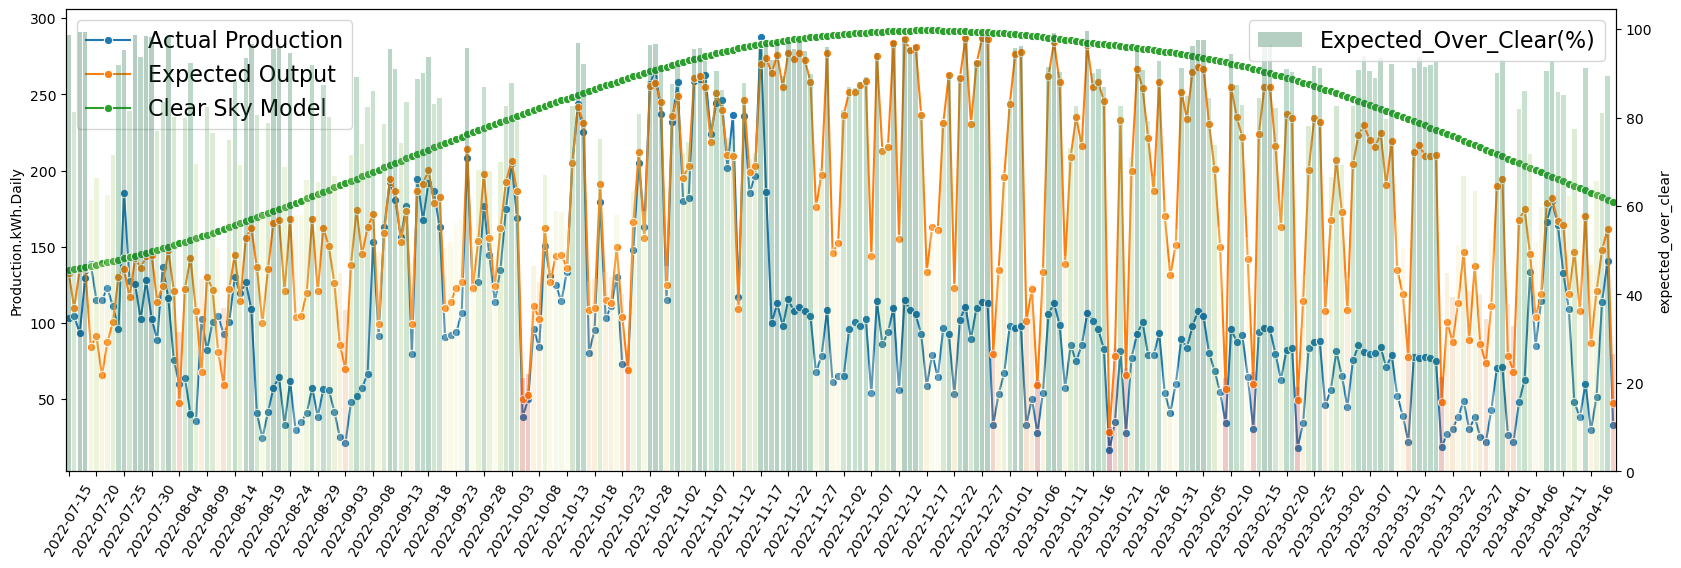

In [122]:
# plot results
# ========================================================
# = Plotting expected_clear_ratio over time
# ========================================================

def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

def plot_pr(df):
    # print(df.head())
    matplotlib.rc_file_defaults()
    ax1 = sns.set_style(style=None, rc=None )
    fig, ax1 = plt.subplots(figsize=(20,6))
    plt.xticks(rotation=60)
    sns.lineplot(data = df[measure_name_actual], marker='o', sort = False, ax=ax1, label = 'Actual Production')
    sns.lineplot(data = df[measure_name_expect],  marker='o', sort = False, ax=ax1, label = 'Expected Output')
    sns.lineplot(data = df[measure_name_clearsky], marker='o', sort = False, ax=ax1, label = 'Clear Sky Model')
    ax2 = ax1.twinx()
    sns.barplot(data = df, x='date', y='expected_over_clear', alpha=0.3, ax=ax2, palette=colors_from_values(df['expected_over_clear'], "RdYlGn"),
                label='Expected_Over_Clear(%)')
    ax1.legend(loc=0, fontsize=16)
    ax2.legend(loc=1, fontsize=16)
    ticks, labels = plt.xticks()
    plt.xticks(ticks[::5], labels[::5])

plot_pr(df=df_pvmeasure)

# 4. PR (Performance Ratio) Calculation

In [123]:
# =============================================================================
# = Plot the Performance Ratio
# =============================================================================
config = dict({'scrollZoom': True})
fig = px.line(df_pvmeasure, x='date', y='Performance_Ratio(%).Daily', markers='o')
fig.show(config=config)
# df_pr[[measure_name_actual, measure_name_expect, measure_name_clearsky]].plot(figsize=(20, 6), marker='o')

In [124]:
# =============================================================================
# = Check the Performance based on different threshold values
# =============================================================================
def performance_check(row):
    if row['Performance_Ratio(%).Daily'] >= 80:
        val = 'ok'
    elif row['Performance_Ratio(%).Daily'] >=60:
        val = 'medium'
    else:
        val = 'under'
    return val

df_pvmeasure['performancelabel_pr'] = df_pvmeasure.apply(performance_check, axis=1)

In [125]:
# df_pvmeasure[(df_pvmeasure['Performance_Ratio(%).Daily']<60) & (df_pvmeasure['is_low_cloudiness_day']==True)]
# df_pvmeasure[df_pvmeasure['is_low_cloudiness_day']==True].iloc[50:, :]
df_pvmeasure.head()

date  Production.kWh.Daily  Irrad.kWh.m2.Daily  \
0  2022-07-15            103.164083          133.029428   
1  2022-07-16            104.527250          109.966491   
2  2022-07-17             93.385417          135.359410   
3  2022-07-18            129.837500          135.830289   
4  2022-07-19            138.444167           84.438051   

   EnergyYield.kWh.Daily  expected_over_clear is_low_cloudiness_day  \
0             134.859982            98.642626                  True   
1             135.522351            81.142697                  True   
2             136.185238            99.393599                  True   
3             136.874952            99.236776                  True   
4             137.592791            61.368078                 False   

   Performance_Ratio(%).Daily performancelabel_pr  
0                   77.549821              medium  
1                   95.053729                  ok  
2                   68.990709              medium  
3                   95.588032                  ok  
4                  163.959453                  ok

# 5. P2P (Performance to Peer) Calculation

In [126]:
# parameters for Performance to Peers
max_distance_for_peers = 10 # km
# P2P_method = 'delta' # division or delta
window_length = 365 # days
thred_nan_num = 30
peak_power_method = 'pvsize' # pvsize or maxvalue

## 5.1. Check if there are peers in the specific distance for the focus PV

In [127]:
# read table needed for P2P calculation, pvsite: peer number in specific distance
# =============== read table and find latitude/longitude of PV sites =================
# pv site table
df_sites_meta = pd.read_csv('../input_data/SITE_nodeType_20230630.csv', header=0)
df_sites_meta = Read_tables_distance(df_sites=df_sites_meta)
df_distance = Cacluate_Read_Peer_Distance(file_path='../preprocessed_data/PVsite_distance_Peers.csv', df_sites=df_sites_meta)

if focus_site_id_full in df_distance['source'].values:
    # check if the focus pv has peers in the constant distance
    df_focus_distance = df_distance[df_distance['source'] == focus_site_id_full]
    peer_number = df_focus_distance['peernumber({}km)'.format(max_distance_for_peers)].values[0]
    print('There are total {} peers in {} km for PV site {}'.format(peer_number, max_distance_for_peers, focus_site_id))
else:
    peer_number = 0
    print('There is no peer in {} km for PV site {} '.format(max_distance_for_peers, focus_site_id))
df_focus_distance

Total_number of PV sites:  1078
Number of PV site without latitude-longitude attribute:  0
Number of PV sites with location information:  1078
Read from the existing file:  ../preprocessed_data/PVsite_distance_Peers.csv
There are total 64 peers in 10 km for PV site b3132ad3-03dd-42f1-ae91-f2230d363669


source  peernumber(1km)  \
421  SITE|b3132ad3-03dd-42f1-ae91-f2230d363669                1   

     peernumber(3km)  peernumber(5km)  peernumber(10km)  peernumber(15km)  \
421               14               38                64                76   

                                          Top0||(km)  \
421  SITE|b528d81b-d6eb-49c8-bf63-f1644dd2b3f1||0.44   

                                          Top1||(km)  \
421  SITE|9d67e5ec-52ee-46be-a6d3-697d323c1feb||1.94   

                                          Top2||(km)  \
421  SITE|7f530288-2782-40dc-9ad4-33415d7af959||1.99   

                                          Top3||(km)  ...  \
421  SITE|f3bba022-f786-472a-af1e-a93a743f6e4b||2.03  ...   

                                         Top40||(km)  \
421  SITE|8251e0e3-6079-4b53-8b4c-ad945d36a893||5.27   

                                         Top41||(km)  \
421  SITE|80aa29c1-e8a9-4194-b1ff-20998a06eb4a||5.38   

                                         Top42||(km)  \
421  SITE|a00c627d-8c49-48e2-a04e-5db676405f16||5.93   

                                         Top43||(km)  \
421  SITE|023f5228-233d-40a7-8687-6747c661eb93||5.93   

                                         Top44||(km)  \
421  SITE|5125d005-e4bd-4a69-9e20-558bd67ade6a||6.12   

                                         Top45||(km)  \
421  SITE|5ec4aa34-5d6d-4ec7-9216-7c5495ac1917||6.41   

                                         Top46||(km)  \
421  SITE|5c47e2d1-6ba6-47ba-ab74-aa034a4936ac||6.46   

                                        Top47||(km)  \
421  SITE|547b793b-6230-4e42-8a7a-6ca3df75b5aa||6.5   

                                         Top48||(km)  \
421  SITE|e4bac0c8-6cce-44ad-b5c3-5a0500be4008||6.54   

                                         Top49||(km)  
421  SITE|f46ebaf9-a2ef-4df3-b52d-2af52e638f0e||6.54  

[1 rows x 56 columns]

## 5.2. Implementation of P2P to a Window: e.g., one week/one month

### 5.2.1. Capacity utilization factor (CUF) Calculation

In [128]:
# ==============================================================
# = calculate the capacity utilization factor (CUF)
# ==============================================================
def Calculate_CUF(df_production, site_id, df_cuf, peak_power):
    df_cuf[site_id] = df_production[site_id].values/(peak_power*24) # for daily resolution
    return df_cuf
# ==============================================================
# #find PV size: some pv site might set pv size as zero
# #If PV size == 0, use the maximum value in the long-term period as the peak power
# ==============================================================
def Calculation_CUF_window(df_effective_peers, df_peakpower, peak_power_method):
    df_cuf = pd.DataFrame(index=range(len(df_effective_peers)))
    df_cuf['date'] = df_effective_peers['date'].values
    for SITE_id in df_effective_peers.columns.to_list()[1:]:
        if peak_power_method == 'pvsize':
            peak_power = df_peakpower[df_peakpower['source']==SITE_id].values[0][1]
        else:
            peak_power = df_peakpower[df_peakpower['source']==SITE_id].values[0][-1]
        if SITE_id == 'Focus_PV':
            print('peak_power:', peak_power)
            print(df_effective_peers[SITE_id])
        # print('peak power:', peak_power)
        df_cuf = Calculate_CUF(df_production=df_effective_peers, site_id=SITE_id, df_cuf=df_cuf, peak_power=peak_power)
        # print('df_cuf:', df_cuf.head())
    return df_cuf

### 5.2.2. Capacity Utilization Ratio (CUR) Calculation

In [129]:
# ==============================================================
# #Calculate Capacity Utilization Ratio (CUR)
# ==============================================================
def Calculate_CUR_window(df_cuf, effective_peers_list):
    df_cur = pd.DataFrame(index=range(len(df_cuf)))
    df_cur['date'] = df_cuf['date'].values
    cuf_focus_pv = df_cuf['Focus_PV'].values
    for peer_id in effective_peers_list:
        peer_cuf = df_cuf[peer_id].values
        cur = np.array([cuf_focus_pv[i]/peer_cuf[i] if peer_cuf[i] !=0 else 0 for i in range(len(cuf_focus_pv))])
        df_cur[peer_id] = cur
    return df_cur

### 5.2.3. Weight Factor Calculation

In [130]:
# ============================================================
# = Calculate the distance between the focus pv and its peers
# ============================================================
def Calculate_Distance(focus_pvid, df_table, pv_list):
    distance_list = []
    latitude_focus_site = df_table[df_table['source']==focus_pvid]['latitude'].values[0]
    longitude_focus_site = df_table[df_table['source']==focus_pvid]['longitude'].values[0]
    coords_1 = (latitude_focus_site, longitude_focus_site)
    for peerid in pv_list:
        lat2 = df_table[df_table['source']==peerid]['latitude'].values[0]
        long2 = df_table[df_table['source']==peerid]['longitude'].values[0]
        coords_2 = (lat2, long2)
        geodis = geopy.distance.geodesic(coords_1, coords_2).km
        distance_list.append(geodis)
    return distance_list

def Weight_Factor_window(df_cur, df_focus_distance, effective_peers_list):
    a_factor=4
    df_weight_factor = pd.DataFrame(index=range(len(effective_peers_list)))
    df_weight_factor['site_id'] = np.array(effective_peers_list)
    mad_cur_list = []
    for site_id in effective_peers_list:
        cur = df_cur[site_id].values
        cur_for_mad = cur[cur != 0]
        # windows at midnight
        if len(cur_for_mad) == 0:
            mad = 0
        else:
            mad = stats.median_abs_deviation(cur_for_mad)
        mad_cur_list.append(mad)
    # print('mad_cur_list:', mad_cur_list)
    weight_factor_list = [1/(math.pow(i, a_factor)) if i != 0 else 0 for i in mad_cur_list]
    # print('weight_factor_list:', weight_factor_list)
    # print('weight_factor_list:', sum(weight_factor_list))
    relative_weight_list = [wj/sum(weight_factor_list) for wj in weight_factor_list]

    df_weight_factor['mad_cur'] = np.array(mad_cur_list)
    df_weight_factor['weight_factor'] = np.array(weight_factor_list)
    df_weight_factor['relative_weight'] = np.array(relative_weight_list)

    df_weight_factor['pvsite_distance'] = np.array([i for i in df_focus_distance.values[0] if str(i).startswith(tuple(effective_peers_list))])
    peer_distance_list = Calculate_Distance(focus_pvid=focus_site_id_full, df_table=df_sites_meta, pv_list=effective_peers_list)
    df_weight_factor['distance(km)'] = np.array(peer_distance_list)

    return df_weight_factor

### 5.2.4. Reference CUF Calculation

In [131]:
# ##================================================================================
# ## Calculate the reference cuf according to CUF_ref =  percentile_50(CUF, weight)
# ##================================================================================
# def Cal_ref_window(df_cuf, df_weight_factor, effective_peers_list):
#     cuf_ref_list = []
#     df_cuf_peers = df_cuf[effective_peers_list]
#     print(df_cuf_peers.head())
#     for i in range(len(df_cuf)):
#         cuf_peers_t = pd.DataFrame(index=range(len(df_cuf_peers.columns.to_list())), columns=['siteid', 'cuf', 'relative_weight'])
#         cuf_peers_t['siteid'] = np.array(df_cuf_peers.columns.to_list())
#         cuf_peers_t['cuf'] = df_cuf_peers.iloc[i, :].values
#         cuf_peers_t['relative_weight'] = cuf_peers_t['siteid'].map(df_weight_factor.set_index('site_id')['relative_weight'])
#         cuf_peers_t['cuf_weight'] = cuf_peers_t['cuf'].values * cuf_peers_t['relative_weight'].values
 
#         cuf_peers_t.sort_values('cuf_weight', inplace=True, ascending=False)
#         per50 = np.percentile(cuf_peers_t['cuf_weight'].values, 50)
#         # print('cur reference idx:', np.where(cuf_peer_sort.values<=per50))
#         idx = np.where(cuf_peers_t['cuf_weight'].values<=per50)[0][0]
#         cuf_ref = cuf_peers_t.iloc[idx, 1]
#         cuf_ref_list.append(cuf_ref)
#     df_cuf['ref_cuf'] = np.array(cuf_ref_list)
#     # df_cuf['ref_cuf'].plot(figsize=(20,4))
#     return df_cuf

In [132]:
##================================================================================
## Calculate the reference cuf according to CUF_ref =  percentile_50(CUF, weight)
##================================================================================
def Cal_ref_window(df_cuf, df_weight_factor, effective_peers_list):
    cuf_ref_list = []
    df_cuf_peers = df_cuf[effective_peers_list].copy()
    for i in range(len(df_cuf)):
        cuf_peers_t = pd.DataFrame(index=range(len(df_cuf_peers.columns.to_list())), columns=['siteid', 'cuf', 'relative_weight'])
        cuf_peers_t['siteid'] = np.array(df_cuf_peers.columns.to_list())
        cuf_peers_t['cuf'] = df_cuf_peers.iloc[i, :].values
        cuf_peers_t['relative_weight'] = cuf_peers_t['siteid'].map(df_weight_factor.set_index('site_id')['relative_weight'])
        cuf_peers_t['cuf_weight'] = cuf_peers_t['cuf'].values * cuf_peers_t['relative_weight'].values
        cuf_peers_t.sort_values('cuf_weight', inplace=True, ascending=False)
        
        cuf_peers_t_withoutzero = cuf_peers_t[cuf_peers_t['cuf']!=0]
        if len(cuf_peers_t_withoutzero) != 0: # all zeros
            cuf_peers_t = cuf_peers_t_withoutzero
  
        per50 = cuf_peers_t['cuf_weight'].quantile(0.50)
        if len(cuf_peers_t)%2 == 0: # even number
            if cuf_peers_t['cuf_weight'].eq(0).all():
                # Find the index corresponding to the 50th percentile value
                df_per50 = cuf_peers_t[cuf_peers_t['cuf_weight'] == per50]
                cuf_ref = df_per50.at[df_per50['relative_weight'].idxmax(), 'cuf']
            else:
                df_per50_larger = cuf_peers_t[cuf_peers_t['cuf_weight']>=per50]
                cuf_ref = df_per50_larger['cuf'].values[0]
            # print('even number')
        else:
            # print('odd number')
            # Find the index corresponding to the 50th percentile value
            df_per50 = cuf_peers_t[cuf_peers_t['cuf_weight'] == per50]
            cuf_ref = df_per50.at[df_per50['relative_weight'].idxmax(), 'cuf']
        cuf_ref_list.append(cuf_ref)
    df_cuf['ref_cuf'] = np.array(cuf_ref_list)
    # df_cuf['ref_cuf'].plot(figsize=(20,4))
    return df_cuf

### 5.2.5. P2P Metric Calculation

In [133]:
##================================================================================
## Calculate the reference cuf according to CUF_ref =  percentile_50(CUF, weight)
##================================================================================
def P2P_metric_cal(df_cuf):
    reference_cuf = df_cuf['ref_cuf'].values
    focus_cuf = df_cuf['Focus_PV'].values
    for p2pcal in ['division', 'delta']:
        if p2pcal == 'division':
            P2P_ref_results = np.array([focus_cuf[c]/(reference_cuf[c]) if reference_cuf[c] !=0 else 0 for c in range(len(focus_cuf))])
            P2P_upperlimit_results = np.array([focus_cuf[c]/(reference_cuf[c]*0.9) if reference_cuf[c] !=0 else 0 for c in range(len(focus_cuf))])
            P2P_lowerlimit_results = np.array([focus_cuf[c]/(reference_cuf[c]*1.1) if reference_cuf[c] !=0 else 0 for c in range(len(focus_cuf))])
            df_cuf['P2P_div_upperlimit'] = P2P_upperlimit_results
            df_cuf['P2P_div_uppererror'] = P2P_upperlimit_results - P2P_ref_results
            df_cuf['P2P_div_lowerlimit'] = P2P_lowerlimit_results
            df_cuf['P2P_div_lowererror'] = P2P_ref_results - P2P_lowerlimit_results
            df_cuf['P2P_ref_div'] = P2P_ref_results
        else:
            P2P_ref_results = np.array(1-(reference_cuf-focus_cuf))
            df_cuf['P2P_ref_delta'] = P2P_ref_results
    return df_cuf

### 5.2.6 Threshold Calculation with P2P in a window

In [134]:
##=======================================================================================
## The reliability of the P2P at a moment t is evaluated as the weighted MAD of CUR_NORM
##======================================================================================
def Cal_phip2p_win(df_curnorm_win, df_weight_factor_win):
    phip2p_list = []
    peers_list = df_weight_factor_win['site_id'].values
    df_curnorm_peers = df_curnorm_win[peers_list]
    for i in range(len(df_curnorm_win)): # same time slot
        curnorm_peers = df_curnorm_peers[peers_list].iloc[i, :] # different peers
        weighted_curnorm_list = []
        for peer in peers_list:
             weighted_curnorm = curnorm_peers[peer]*df_weight_factor_win[df_weight_factor_win['site_id']==peer]['relative_weight'].values
             weighted_curnorm_list.append(weighted_curnorm[0])
        weighted_curnorm_vector = np.array(weighted_curnorm_list)
        if np.all(weighted_curnorm_vector==0):
            phip2p = 0
        else:
            weighted_curnorm_vector = weighted_curnorm_vector[weighted_curnorm_vector!=0]
            phip2p = stats.median_abs_deviation(weighted_curnorm_vector)
        phip2p_list.append(phip2p)
    df_curnorm_win['phip2p'] = np.array(phip2p_list)
    return df_curnorm_win 

In [135]:
##================================================================================
## Calculate the threshold value according to P2P values for fault detection
##================================================================================
def calculate_p2p_threshold(p2p_ref, phip2p, z, xi_p2p):
    p2p_ref_median = p2p_ref[p2p_ref != 0]
    meidian_p2p = np.median(p2p_ref_median)
    confidence_interval_p2p = (z*phip2p + xi_p2p)*meidian_p2p
    thred = np.array([meidian_p2p - confidence_interval_p2p[i] if phip2p[i]!=0 else 0 for i in range(len(phip2p))])
    return thred

def p2p_fault_detection_win(df_cuf_win, df_cur_win, df_weight_win, z, xi_p2p):
    # z: the number of standard deviations by which the value is away from the mean value, z=3
    # xi_p2p: $\xi_{p2p}$ is introduced to provide a tolerance margin to the donfidence interval, xi_p2p =5%
    # # some metrics for fault detection
    df_curnorm_win = pd.DataFrame(index=np.arange(len(df_cuf_win)), columns=['date'])
    df_curnorm_win['date'] = df_cuf_win['date'].values
    mids_list = [x for x in df_cuf_win.columns.to_list() if x.startswith('SITE')]
    # 1. calcualte the CUR_NORM
    for mnr in mids_list:
        cur = df_cur_win[mnr].values
        cur_for_norm = cur[cur != 0]
        cur_norm = cur/(np.median(cur_for_norm))
        df_curnorm_win[mnr] = cur_norm
    # 2. calculate the Phi_p2p to evaluate the reliability of the P2P at each time slot t
    df_curnorm_win = Cal_phip2p_win(df_curnorm_win=df_curnorm_win, df_weight_factor_win=df_weight_win)
    # 3. calculate the confidence interval around P2P and threshold value for fault detection
    for p2p_method in ['division', 'delta']:
        if p2p_method == 'division':
            p2p_ref = df_cuf_win['P2P_ref_div'].values
            thred = calculate_p2p_threshold(p2p_ref=p2p_ref, phip2p=df_curnorm_win['phip2p'].values, z=z, xi_p2p=xi_p2p)
            df_curnorm_win['thred_div'] = thred
        else:
            p2p_ref = df_cuf_win['P2P_ref_delta'].values
            thred = calculate_p2p_threshold(p2p_ref=p2p_ref, phip2p=df_curnorm_win['phip2p'].values, z=z, xi_p2p=xi_p2p)
            df_curnorm_win['thred_delta'] = thred
    return df_curnorm_win

### 5.2.7 Whole Function for P2P calculation

In [136]:
##================================================================================
## Calculate the P2P in a window
##================================================================================
def P2P_window(df_effective_peers, df_focus_distance, df_peakpower, effective_peers_list, peak_power_method):
    print('2.1. Calcuate CUF in a window')
    # print(df_effective_peers.head())
    df_cuf_win = Calculation_CUF_window(df_effective_peers=df_effective_peers, df_peakpower=df_peakpower, peak_power_method=peak_power_method)
    # print('cuf calcualtion:', df_cuf_win.head())
    print('2.2. Calculate CUR in a window')
    df_cur_win = Calculate_CUR_window(df_cuf=df_cuf_win, effective_peers_list=effective_peers_list)
    # print('cur calculation:', df_cur_win.head())
    print('2.3. Calcualte weight factors of its peers in a window')
    df_weight_factor_win = Weight_Factor_window(df_cur=df_cur_win, df_focus_distance=df_focus_distance, effective_peers_list=effective_peers_list)
    # print('weight factor:', df_weight_factor_win.head())
    print('2.4. Calcualte the reference CUF in a window')
    # reference cuf
    df_cuf_win = Cal_ref_window(df_cuf=df_cuf_win, df_weight_factor=df_weight_factor_win, effective_peers_list=effective_peers_list)
    # print('reference cuf:', df_cuf_win.head())
    print('2.5. Calcualte the P2P metric in a window')
    # calculate P2P
    df_cuf_win = P2P_metric_cal(df_cuf=df_cuf_win)
    print('P2P:', df_cuf_win.head())
    # calculate the dynamic threshold value
    print('2.6. Calculate the threshold for fault detection')
    df_curnorm_win = p2p_fault_detection_win(df_cuf_win=df_cuf_win, df_cur_win=df_cuf_win, df_weight_win=df_weight_factor_win, z=3, xi_p2p=0.05)
    # print(df_cuf_win.head())
    # print(df_cur_win.head())
    # print(df_curnorm_win.head())
    return df_cuf_win, df_cur_win,  df_curnorm_win, df_weight_factor_win

## 5.3. Find Effective Peers in different windows

In [137]:
##================================================================================
## Process the missing data in a window, including zero values
##================================================================================
def Process_missdata_window(df_peers_production_window, thred_nan_num):
    # check if the focus pv has missing data and data with zero values
    focus_pv_nannum = df_peers_production_window['Focus_PV'].isnull().sum()
    focus_pv_zeronum = len(df_peers_production_window[df_peers_production_window['Focus_PV']==0])

    print('Focus PV: there are {} days with missing data and {} days with zero values'.format(focus_pv_nannum, focus_pv_zeronum))
    if focus_pv_nannum + focus_pv_zeronum > thred_nan_num:
        print('The focus PV has too many missing data, return None')
        return None
    else:
        df_peers_production_window['Focus_PV'] = df_peers_production_window['Focus_PV'].interpolate(method='nearest')
        peers_win_list = df_peers_production_window.columns.to_list()[2:]
        print('There ae total {} peers before processing missing data'.format(len(peers_win_list)))
        for peer_id in peers_win_list:
            peer_nannum = df_peers_production_window[peer_id].isnull().sum()
            peer_zeronum = len(df_peers_production_window[df_peers_production_window[peer_id]==0])
            if peer_nannum + peer_zeronum > thred_nan_num:
                # too many missing days, drop this peer for P2P calculation
                df_peers_production_window.drop(peer_id, axis=1, inplace=True)
            elif (peer_nannum + peer_zeronum > 0) & (peer_nannum + peer_zeronum<=thred_nan_num):
                # fill in the missing/zero data with nearest one
                df_peers_production_window[peer_id] = df_peers_production_window[peer_id].interpolate(method='nearest')
            else:
                df_peers_production_window = df_peers_production_window
        # there is no peers
        if len(df_peers_production_window.columns.str.startswith('SITE'))==0:
            return None
        else:
            return df_peers_production_window

In [138]:
##================================================================================
## Find how many peers can be used for P2P calculation in this window
##================================================================================
def Find_effective_peers_window(df_peers_production_window, thred_nan_num):
    print('====== 1. Find effective peers in a window: from {} to {} ============='.format(df_peers_production_window.iloc[0, 0],
                                                                                                              df_peers_production_window.iloc[-1, 0]))
    # Note that the first column is the Focus PV
    # 1 missing data tollerance in one-week window and 4 missing data tollerance in one-month window
    print('Process the missing data in a window')
    df_effective_peers_window = Process_missdata_window(df_peers_production_window=df_peers_production_window, thred_nan_num=thred_nan_num)
    # the focus pv has too many missing day or there is no effecive peers (too many missing day of it's peers)
    if df_effective_peers_window is None:
        print('There are No effective peers in {} km'.format(max_distance_for_peers))
        return None
    else:
        focus_effective_peers_win_list = df_effective_peers_window.columns.to_list()[1:]
        effective_peers_win_list = df_effective_peers_window.columns.to_list()[2:]
        print('There are {} effective peers in {} km after preprocessing missing data'.format(len(effective_peers_win_list), max_distance_for_peers))
        # remove outliers: negative points
        df_remove_negative = df_effective_peers_window[focus_effective_peers_win_list][df_effective_peers_window[focus_effective_peers_win_list] > 0].fillna(0)
        df_effective_peers_window[focus_effective_peers_win_list] = df_remove_negative
        return [df_effective_peers_window, effective_peers_win_list]

## 5.4. P2P Calculation in time period

### 5.4.1. Peak Power

In [139]:
##================================================================================
## Peak Power for CUF calculation, 
## PV size or maximum value of PV expected generationin the time period
##================================================================================
def Read_PVsize(df_sites_meta, df_all_pv):
    pvsites_list = df_pvactual.columns.to_list()[1:]
    df_peakpower = pd.DataFrame(index=range(len(pvsites_list)))
    df_peakpower['source'] = np.array(pvsites_list)
    df_peakpower.loc[df_peakpower['source']==focus_site_id_full, 'source'] = 'Focus_PV' 
    pvsize_list = []
    pvsize_max_list = []
    maxvalue_list = []
    for pvsite_id in pvsites_list:
        pvsize = df_sites_meta[df_sites_meta['source']==pvsite_id]['pvSizeWatt'].values# watt --> kw
        if len(pvsize) == 0:
            pvsize = np.nan
        else:
            pvsize= pvsize[0]/1000*4/24
        if pvsize == np.nan:
            pvsize = df_all_pv[pvsite_id].max()/24
        pvsize_list.append(pvsize)
        pvsize_max_list.append(pvsize)
        maxvalue_list.append(df_all_pv[pvsite_id].max()/24)
    df_peakpower['pvsize(kw)'] = np.array(pvsize_list)
    df_peakpower['pvsize_max(kw)'] = np.array(pvsize_max_list)
    df_peakpower['max_value(kw)'] = np.array(maxvalue_list)
    return df_peakpower

df_pvactual = df_site.filter(like=measure_name_actual)
split_columns = df_pvactual.columns.str.split(':').str[1]
df_pvactual.columns = split_columns
df_pvactual.insert(0, 'date', df_site['date'].values)
df_peakpower = Read_PVsize(df_sites_meta=df_sites_meta, df_all_pv=df_pvactual)
df_peakpower = df_peakpower.dropna(subset=['max_value(kw)'])
df_peakpower

source  pvsize(kw)  pvsize_max(kw)  \
0     SITE|65e61db2-2bb3-4480-b495-96064d5ed331    0.000000        0.000000   
1     SITE|4dddc226-3464-4c95-aded-875e490a2f02    1.560000        1.560000   
2     SITE|d830cf82-d943-404a-8396-9b22141538a8   16.636667       16.636667   
3     SITE|c9fcf61f-c1a9-48d8-b2bb-c843dbd69119    1.100000        1.100000   
4     SITE|09640f46-ed55-45be-b243-dbbe126fc994    0.000000        0.000000   
...                                         ...         ...             ...   
1071  SITE|93dcd16f-e2e9-422c-9099-fa50c46998a5   15.563333       15.563333   
1072  SITE|ef7f758c-4612-4025-acc4-47cfec16891f   16.661667       16.661667   
1074  SITE|6577b77e-93fe-486b-bc95-b77c5ce6a18e    4.500000        4.500000   
1075  SITE|4229b257-cc70-4d03-8c0a-1f0d930d792e   40.973333       40.973333   
1077  SITE|49965a47-7a49-4866-a11f-06cb600ac967   16.650000       16.650000   

      max_value(kw)  
0          5.833747  
1          1.565720  
2         25.687601  
3          1.702170  
4          1.263545  
...             ...  
1071      14.899253  
1072      25.390003  
1074       6.757781  
1075     809.134276  
1077      28.094875  

[871 rows x 4 columns]

### 5.4.2. Read Actual/Expected Generation

In [140]:
df_p2p = df_pvmeasure.copy()
# ==============================================================
# #read the actual generation of it's peers
# ==============================================================
df_focus_peers = df_focus_distance[df_focus_distance.columns[pd.Series(df_focus_distance.columns).str.startswith('Top')]]
peers_list = df_focus_peers.values[0]
# create dataframe to save the daily actual production of the peers
df_peers_production = pd.DataFrame(index=range(len(df_p2p)))
df_peers_production['date'] = df_p2p['date'].values
df_peers_production['Focus_PV'] = df_p2p[measure_name_actual].values
# create dataframe to save the daily expected production of the peers
df_peers_expected = pd.DataFrame(index=range(len(df_p2p)))
df_peers_expected['date'] = df_p2p['date'].values
df_peers_expected['Focus_PV'] = df_p2p[measure_name_expect].values
# align peers' production
for peerid_with_distance in peers_list[0:peer_number]:
    peerid_SITE = peerid_with_distance.split('||')[0]
    peer_id = peerid_SITE.split('|')[1]
    df_peers_production[peerid_SITE] = df_peers_production['date'].map(df_pvactual.set_index('date')[peerid_SITE])
    df_peers_expected[peerid_SITE] = df_peers_expected['date'].map(df_pvactual.set_index('date')[peerid_SITE])
df_peers_production

date    Focus_PV  SITE|b528d81b-d6eb-49c8-bf63-f1644dd2b3f1  \
0    2022-07-15  103.164083                                 140.743989   
1    2022-07-16  104.527250                                  90.375741   
2    2022-07-17   93.385417                                 142.195437   
3    2022-07-18  129.837500                                 144.856677   
4    2022-07-19  138.444167                                  76.125845   
..          ...         ...                                        ...   
275  2023-04-16   29.702583                                  74.254250   
276  2023-04-17   51.547250                                 127.923750   
277  2023-04-18  113.984250                                 134.421500   
278  2023-04-19  140.763583                                 173.088250   
279  2023-04-20   33.059083                                  35.930500   

     SITE|9d67e5ec-52ee-46be-a6d3-697d323c1feb  \
0                                          NaN   
1                                          NaN   
2                                          NaN   
3                                          NaN   
4                                          NaN   
..                                         ...   
275                                        NaN   
276                                        NaN   
277                                        NaN   
278                                        NaN   
279                                        NaN   

     SITE|7f530288-2782-40dc-9ad4-33415d7af959  \
0                                          NaN   
1                                          NaN   
2                                          NaN   
3                                          NaN   
4                                          NaN   
..                                         ...   
275                                        NaN   
276                                        NaN   
277                                        NaN   
278                                        NaN   
279                                        NaN   

     SITE|f3bba022-f786-472a-af1e-a93a743f6e4b  \
0                                          NaN   
1                                          NaN   
2                                          NaN   
3                                          NaN   
4                                          NaN   
..                                         ...   
275                                        NaN   
276                                        NaN   
277                                        NaN   
278                                        NaN   
279                                        NaN   

     SITE|47a412c4-f3f3-4709-b2a7-b72026975a1f  \
0                                          NaN   
1                                          NaN   
2                                          NaN   
3                                          NaN   
4                                          NaN   
..                                         ...   
275                                        NaN   
276                                        NaN   
277                                        NaN   
278                                        NaN   
279                                        NaN   

     SITE|8659a423-4159-4b11-a43c-c246c2cf0b3c  \
0                                    27.890833   
1                                    17.476083   
2                                    27.617250   
3                                    29.021917   
4                                    16.633500   
..                                         ...   
275                                  14.005500   
276                                  28.962667   
277                                  29.550083   
278                                  34.556917   
279                                   7.549917   

     SITE|b3d272b7-c9f5-409d-b1f6-2b552eef4210  \
0                                    13.597417   
1                


### 5.4.3. Outlier preprocessing

In [141]:
df_peers_production.loc[df_peers_production['Focus_PV']>df_peers_expected['Focus_PV']*2.0, 'Focus_PV']

Series([], Name: Focus_PV, dtype: float64)

In [142]:
# ======================================================================
# #remove the outlier: 
# # outlier: the actual PV generation is larger than the expected values
# ======================================================================
focus_effective_peers_list = df_peers_expected.columns.to_list()[1:]
for site_id in focus_effective_peers_list:
    pv_expected = df_peers_expected[site_id] # Fiacre: 1.1 might too small
    df_peers_production.loc[df_peers_production[site_id]>1.4*pv_expected, site_id] = np.nan
    df_peers_production.loc[df_peers_production[site_id]<0, site_id] = 0

In [143]:
df_peers_production

date    Focus_PV  SITE|b528d81b-d6eb-49c8-bf63-f1644dd2b3f1  \
0    2022-07-15  103.164083                                 140.743989   
1    2022-07-16  104.527250                                  90.375741   
2    2022-07-17   93.385417                                 142.195437   
3    2022-07-18  129.837500                                 144.856677   
4    2022-07-19         NaN                                  76.125845   
..          ...         ...                                        ...   
275  2023-04-16   29.702583                                  74.254250   
276  2023-04-17   51.547250                                 127.923750   
277  2023-04-18  113.984250                                 134.421500   
278  2023-04-19  140.763583                                 173.088250   
279  2023-04-20   33.059083                                  35.930500   

     SITE|9d67e5ec-52ee-46be-a6d3-697d323c1feb  \
0                                          NaN   
1                                          NaN   
2                                          NaN   
3                                          NaN   
4                                          NaN   
..                                         ...   
275                                        NaN   
276                                        NaN   
277                                        NaN   
278                                        NaN   
279                                        NaN   

     SITE|7f530288-2782-40dc-9ad4-33415d7af959  \
0                                          NaN   
1                                          NaN   
2                                          NaN   
3                                          NaN   
4                                          NaN   
..                                         ...   
275                                        NaN   
276                                        NaN   
277                                        NaN   
278                                        NaN   
279                                        NaN   

     SITE|f3bba022-f786-472a-af1e-a93a743f6e4b  \
0                                          NaN   
1                                          NaN   
2                                          NaN   
3                                          NaN   
4                                          NaN   
..                                         ...   
275                                        NaN   
276                                        NaN   
277                                        NaN   
278                                        NaN   
279                                        NaN   

     SITE|47a412c4-f3f3-4709-b2a7-b72026975a1f  \
0                                          NaN   
1                                          NaN   
2                                          NaN   
3                                          NaN   
4                                          NaN   
..                                         ...   
275                                        NaN   
276                                        NaN   
277                                        NaN   
278                                        NaN   
279                                        NaN   

     SITE|8659a423-4159-4b11-a43c-c246c2cf0b3c  \
0                                    27.890833   
1                                    17.476083   
2                                    27.617250   
3                                    29.021917   
4                                    16.633500   
..                                         ...   
275                                  14.005500   
276                                  28.962667   
277                                  29.550083   
278                                  34.556917   
279                                   7.549917   

     SITE|b3d272b7-c9f5-409d-b1f6-2b552eef4210  \
0                                    13.597417   
1                

### 5.5.4. Split windows

In [144]:
window_num, less_window = divmod(len(df_peers_production), window_length)
print('There are total %d windows with each window contains %d days' % (window_num, window_length))
print('There are %d days left less than a window' % less_window)

There are total 0 windows with each window contains 365 days
There are 280 days left less than a window


### 5.5.5. Calculate the P2P in a window

In [145]:
# ======================================================================================================
# The days left larger than the days of half in a window, we consider it as a window for P2P calculation
# ======================================================================================================
if less_window > int(window_length/2):
    window_num_total = window_num + 1
else:
    window_num_total = window_num
print('total window number:', window_num_total)
# initialisation
df_p2p_results = pd.DataFrame()
# should plot in a window length
df_weight_factor = pd.DataFrame()
# for wn in np.arange(26, window_num_total, 1):
if window_num != 0:
    for wn in range(window_num_total):
        if wn < window_num_total -1:
            window_start = wn*window_length
            window_end = (wn+1)*window_length
        else:
            window_start = wn*window_length
            window_end = len(df_peers_production)-1
        # pv actual generation of the focus pv and its peers in a window
        df_peers_production_window = df_peers_production.iloc[window_start:window_end, :]
        print('=****************************** window {}: from {} to {} ************************************='.format(wn, df_peers_production.iloc[window_start, 0], 
                                                                                                                    df_peers_production.iloc[window_end, 0]))
        if wn == window_num_total - 1:
            print('========== start to process the last one winow with {} days ==================='.format(less_window))
        # find the effective peers in a window
        effective_peers_results = Find_effective_peers_window(df_peers_production_window=df_peers_production_window, thred_nan_num=thred_nan_num)
        if effective_peers_results is None:
            print('There is no peer from {} to {}'.format(df_peers_production.iloc[window_start, 0], df_peers_production.iloc[window_end, 0]))
        else:
            print('======= 2. Calcuate P2P in a window from {} to {} ======='.format(df_peers_production.iloc[window_start, 0], df_peers_production.iloc[window_end, 0]))
            # calculate the p2p in a windows with effective peers
            df_effective_peers_window, effective_peers_window_list = effective_peers_results
            df_cuf_window, df_cur_window, df_curnorm_window, df_weight_factor_window = P2P_window(df_effective_peers=df_effective_peers_window, 
                                                                                                  df_focus_distance=df_focus_distance, 
                                                                                                  df_peakpower=df_peakpower, 
                                                                                                  effective_peers_list=effective_peers_window_list,
                                                                                                  peak_power_method=peak_power_method)
            concern_list = [idx for idx in df_cuf_window.columns.to_list() if not idx.startswith('SITE')]
            # print('concern list:', concern_list)
            df_concern = df_cuf_window[concern_list]
            df_concern['thred_div'] = df_curnorm_window['thred_div'].values
            df_concern['thred_delta'] = df_curnorm_window['thred_delta'].values
            df_concern['peers_num'] = len(effective_peers_window_list)

            df_weight_factor_window['window_No.'] = wn
            if wn == 0:
                df_p2p_results = df_concern
                df_weight_factor = df_weight_factor_window 
            else:
                df_p2p_results = df_p2p_results.append(df_concern)
                df_weight_factor = df_weight_factor.append(df_weight_factor_window)
else:
    print('#*********************************** Calcuate the P2P without Window Sliding *************************#')
    # pv actual generation of the focus pv and its peers in a window
    effective_peers_results = Find_effective_peers_window(df_peers_production_window=df_peers_production, thred_nan_num=thred_nan_num)
    if effective_peers_results is None:
        print('There is no peer from {} to {}'.format(df_peers_production.iloc[0, 0], df_peers_production.iloc[-1, 0]))
    else:
        print('======= 2. Calcuate P2P in a window from {} to {} ======='.format(df_peers_production.iloc[0, 0], df_peers_production.iloc[-1, 0]))
    # calculate the p2p in a windows with effective peers
    df_effective_peers_window, effective_peers_window_list = effective_peers_results
    df_cuf, df_cur, df_curnorm, df_weight_factor = P2P_window(df_effective_peers=df_effective_peers_window, 
                                                              df_focus_distance=df_focus_distance, df_peakpower=df_peakpower, 
                                                              effective_peers_list=effective_peers_window_list,
                                                              peak_power_method=peak_power_method)
    print(df_cuf)
    concern_list = [idx for idx in df_cuf.columns.to_list() if not idx.startswith('SITE')]
    # print('concern list:', concern_list)
    df_concern = df_cuf[concern_list]
    df_concern['thred_div'] = df_curnorm['thred_div'].values
    df_concern['thred_delta'] = df_curnorm['thred_delta'].values
    df_concern['peers_num'] = len(effective_peers_window_list)
    df_p2p_results = df_concern 
df_p2p_results
    

total window number: 1
#*********************************** Calcuate the P2P without Window Sliding *************************#
====== 1. Find effective peers in a window: from 2022-07-15 to 2023-04-20 =============
Process the missing data in a window
Focus PV: there are 5 days with missing data and 0 days with zero values
There ae total 50 peers before processing missing data
There are 23 effective peers in 10 km after preprocessing missing data
======= 2. Calcuate P2P in a window from 2022-07-15 to 2023-04-20 =======
2.1. Calcuate CUF in a window
peak_power: 6.416666666666667
0      103.164083
1      104.527250
2       93.385417
3      129.837500
4      129.837500
          ...    
275     29.702583
276     51.547250
277    113.984250
278    140.763583
279     33.059083
Name: Focus_PV, Length: 280, dtype: float64
2.2. Calculate CUR in a window
2.3. Calcualte weight factors of its peers in a window
2.4. Calcualte the reference CUF in a window
2.5. Calcualte the P2P metric in a window


date  Focus_PV   ref_cuf  P2P_div_upperlimit  P2P_div_uppererror  \
0    2022-07-15  0.669897  1.023071            0.727545            0.072754   
1    2022-07-16  0.678748  0.391406            1.926808            0.192681   
2    2022-07-17  0.606399  1.035496            0.650680            0.065068   
3    2022-07-18  0.843101  1.060603            0.883251            0.088325   
4    2022-07-19  0.843101  0.340606            2.750331            0.275033   
..          ...       ...       ...                 ...                 ...   
275  2023-04-16  0.192874  0.418374            0.512232            0.051223   
276  2023-04-17  0.334722  0.558939            0.665392            0.066539   
277  2023-04-18  0.740157  0.578832            1.420787            0.142079   
278  2023-04-19  0.914049  0.853505            1.189929            0.118993   
279  2023-04-20  0.214669  0.120930            1.972397            0.197240   

     P2P_div_lowerlimit  P2P_div_lowererror  P2P_ref_div  P2P_ref_delta  \
0              0.595264            0.059526     0.654790       0.646826   
1              1.576480            0.157648     1.734128       1.287342   
2              0.532375            0.053237     0.585612       0.570903   
3              0.722660            0.072266     0.794926       0.782498   
4              2.250271            0.225027     2.475298       1.502495   
..                  ...                 ...          ...            ...   
275            0.419099            0.041910     0.461009       0.774500   
276            0.544412            0.054441     0.598853       0.775783   
277            1.162462            0.116246     1.278708       1.161325   
278            0.973578            0.097358     1.070936       1.060545   
279            1.613779            0.161378     1.775157       1.093740   

     thred_div  thred_delta  peers_num  
0     0.468810     0.641069         23  
1     0.481624     0.658592         23  
2     0.468689     0.640904         23  
3     0.469283     0.641716         23  
4     0.482752     0.660135         23  
..         ...          ...        ...  
275   0.481160     0.657958         23  
276   0.464655     0.635388         23  
277   0.471000     0.644065         23  
278   0.462826     0.632887         23  
279   0.492387     0.673310         23  

[280 rows x 12 columns]

In [163]:
df_p2p_results

date  Focus_PV   ref_cuf  P2P_div_upperlimit  P2P_div_uppererror  \
0    2022-07-15  0.669897  1.023071            0.727545            0.072754   
1    2022-07-16  0.678748  0.391406            1.926808            0.192681   
2    2022-07-17  0.606399  1.035496            0.650680            0.065068   
3    2022-07-18  0.843101  1.060603            0.883251            0.088325   
4    2022-07-19  0.843101  0.340606            2.750331            0.275033   
..          ...       ...       ...                 ...                 ...   
275  2023-04-16  0.192874  0.418374            0.512232            0.051223   
276  2023-04-17  0.334722  0.558939            0.665392            0.066539   
277  2023-04-18  0.740157  0.578832            1.420787            0.142079   
278  2023-04-19  0.914049  0.853505            1.189929            0.118993   
279  2023-04-20  0.214669  0.120930            1.972397            0.197240   

     P2P_div_lowerlimit  P2P_div_lowererror  P2P_ref_div  P2P_ref_delta  \
0              0.595264            0.059526     0.654790       0.646826   
1              1.576480            0.157648     1.734128       1.287342   
2              0.532375            0.053237     0.585612       0.570903   
3              0.722660            0.072266     0.794926       0.782498   
4              2.250271            0.225027     2.475298       1.502495   
..                  ...                 ...          ...            ...   
275            0.419099            0.041910     0.461009       0.774500   
276            0.544412            0.054441     0.598853       0.775783   
277            1.162462            0.116246     1.278708       1.161325   
278            0.973578            0.097358     1.070936       1.060545   
279            1.613779            0.161378     1.775157       1.093740   

     thred_div  thred_delta  peers_num  
0     0.468810     0.641069         23  
1     0.481624     0.658592         23  
2     0.468689     0.640904         23  
3     0.469283     0.641716         23  
4     0.482752     0.660135         23  
..         ...          ...        ...  
275   0.481160     0.657958         23  
276   0.464655     0.635388         23  
277   0.471000     0.644065         23  
278   0.462826     0.632887         23  
279   0.492387     0.673310         23  

[280 rows x 12 columns]

# 6. Combine P2P and PR results

In [171]:
df_p2p_pr = df_p2p_results.copy()

df_p2p_pr[measure_name_expect] = df_p2p_pr['date'].map(df_pvmeasure.set_index('date')[measure_name_expect])
df_p2p_pr['is_low_cloudiness_day'] = df_p2p_pr['date'].map(df_pvmeasure.set_index('date')['is_low_cloudiness_day'])
df_p2p_pr['Performance_Ratio(%).Daily'] = df_p2p_pr['date'].map(df_pvmeasure.set_index('date')['Performance_Ratio(%).Daily'])
df_p2p_pr['Performance_Label_PR'] = df_p2p_pr['date'].map(df_pvmeasure.set_index('date')['performancelabel_pr'])
df_p2p_pr

date  Focus_PV   ref_cuf  P2P_div_upperlimit  P2P_div_uppererror  \
0    2022-07-15  0.669897  1.023071            0.727545            0.072754   
1    2022-07-16  0.678748  0.391406            1.926808            0.192681   
2    2022-07-17  0.606399  1.035496            0.650680            0.065068   
3    2022-07-18  0.843101  1.060603            0.883251            0.088325   
4    2022-07-19  0.843101  0.340606            2.750331            0.275033   
..          ...       ...       ...                 ...                 ...   
275  2023-04-16  0.192874  0.418374            0.512232            0.051223   
276  2023-04-17  0.334722  0.558939            0.665392            0.066539   
277  2023-04-18  0.740157  0.578832            1.420787            0.142079   
278  2023-04-19  0.914049  0.853505            1.189929            0.118993   
279  2023-04-20  0.214669  0.120930            1.972397            0.197240   

     P2P_div_lowerlimit  P2P_div_lowererror  P2P_ref_div  P2P_ref_delta  \
0              0.595264            0.059526     0.654790       0.646826   
1              1.576480            0.157648     1.734128       1.287342   
2              0.532375            0.053237     0.585612       0.570903   
3              0.722660            0.072266     0.794926       0.782498   
4              2.250271            0.225027     2.475298       1.502495   
..                  ...                 ...          ...            ...   
275            0.419099            0.041910     0.461009       0.774500   
276            0.544412            0.054441     0.598853       0.775783   
277            1.162462            0.116246     1.278708       1.161325   
278            0.973578            0.097358     1.070936       1.060545   
279            1.613779            0.161378     1.775157       1.093740   

     thred_div  thred_delta  peers_num  Irrad.kWh.m2.Daily  \
0     0.468810     0.641069         23          133.029428   
1     0.481624     0.658592         23          109.966491   
2     0.468689     0.640904         23          135.359410   
3     0.469283     0.641716         23          135.830289   
4     0.482752     0.660135         23           84.438051   
..         ...          ...        ...                 ...   
275   0.481160     0.657958         23           86.598424   
276   0.464655     0.635388         23          120.904264   
277   0.471000     0.644065         23          147.905811   
278   0.462826     0.632887         23          161.669772   
279   0.492387     0.673310         23           47.717389   

    is_low_cloudiness_day  Performance_Ratio(%).Daily Performance_Label_PR  
0                    True                   77.549821               medium  
1                    True                   95.053729                   ok  
2                    True                   68.990709               medium  
3                    True                   95.588032                   ok  
4                   False                  163.959453                   ok  
..                    ...                         ...                  ...  
275                 False                   34.299219                under  
276                 False                   42.634766                under  
277                  True                   77.065431               medium  
278                  True                   87.068585                   ok  
279                 False                   69.280997               medium  

[280 rows x 16 columns]

In [172]:
def performance_p2p_delta(row):
    if (row['P2P_ref_delta'] >= row['thred_delta']) & (row['P2P_ref_delta']<=1.5):
        val = 'ok'
    elif row['P2P_ref_delta'] > 1.5:
        val = 'over'
    else:
        val = 'under'
    return val
def performance_delta_constant(row):
    if (row['P2P_ref_delta'] >= 0.8) & (row['P2P_ref_delta']<=1.5):
        val = 'ok'
    elif row['P2P_ref_delta'] > 1.5:
        val = 'over'
    elif row['P2P_ref_delta'] > 0.6:
        val = 'medium'
    else:
        val = 'under'
    return val

df_p2p_pr['Performance_Label_P2P_delta'] = df_p2p_pr.apply(performance_p2p_delta, axis=1)
df_p2p_pr['Perfomrnace_P2P_constant_delta'] = df_p2p_pr.apply(performance_delta_constant, axis=1)
df_p2p_pr[df_p2p_pr['Performance_Label_P2P_delta']=='ok'].head()

date  Focus_PV   ref_cuf  P2P_div_upperlimit  P2P_div_uppererror  \
0  2022-07-15  0.669897  1.023071            0.727545            0.072754   
1  2022-07-16  0.678748  0.391406            1.926808            0.192681   
3  2022-07-18  0.843101  1.060603            0.883251            0.088325   
5  2022-07-20  0.749316  0.331491            2.511601            0.251160   
6  2022-07-21  0.749316  0.272140            3.059355            0.305936   

   P2P_div_lowerlimit  P2P_div_lowererror  P2P_ref_div  P2P_ref_delta  \
0            0.595264            0.059526     0.654790       0.646826   
1            1.576480            0.157648     1.734128       1.287342   
3            0.722660            0.072266     0.794926       0.782498   
5            2.054946            0.205495     2.260441       1.417825   
6            2.503109            0.250311     2.753420       1.477176   

   thred_div  thred_delta  peers_num  Irrad.kWh.m2.Daily  \
0   0.468810     0.641069         23          133.029428   
1   0.481624     0.658592         23          109.966491   
3   0.469283     0.641716         23          135.830289   
5   0.483935     0.661752         23           91.844388   
6   0.487656     0.666840         23           65.624597   

  is_low_cloudiness_day  Performance_Ratio(%).Daily Performance_Label_PR  \
0                  True                   77.549821               medium   
1                  True                   95.053729                   ok   
3                  True                   95.588032                   ok   
5                 False                  125.641499                   ok   
6                 False                  175.652824                   ok   

  Performance_Label_P2P_delta Perfomrnace_P2P_constant_delta  
0                          ok                         medium  
1                          ok                             ok  
3                          ok                         medium  
5                          ok                             ok  
6                          ok                             ok

In [173]:
def performance_p2p_div(row):
    if (row['P2P_ref_div'] >= row['thred_div']) & (row['P2P_ref_div']<=1.5):
        val = 'ok'
    elif row['P2P_ref_div'] > 1.5:
        val = 'over'
    else:
        val = 'under'
    return val
def performance_div_constant(row):
    if (row['P2P_ref_div'] >= 0.8) & (row['P2P_ref_div']<=1.5):
        val = 'ok'
    elif row['P2P_ref_div'] > 1.5:
        val = 'over'
    elif row['P2P_ref_div'] > 0.6:
        val = 'medium'
    else:
        val = 'under'
    return val

def performance_mix_constant(row):
    if (row['P2P_ref_mix'] >= 0.8) & (row['P2P_ref_mix']<=1.5):
        val = 'ok'
    elif row['P2P_ref_mix'] > 1.5:
        val = 'over'
    elif row['P2P_ref_mix'] > 0.6:
        val = 'medium'
    else:
        val = 'under'
    return val
df_p2p_pr

date  Focus_PV   ref_cuf  P2P_div_upperlimit  P2P_div_uppererror  \
0    2022-07-15  0.669897  1.023071            0.727545            0.072754   
1    2022-07-16  0.678748  0.391406            1.926808            0.192681   
2    2022-07-17  0.606399  1.035496            0.650680            0.065068   
3    2022-07-18  0.843101  1.060603            0.883251            0.088325   
4    2022-07-19  0.843101  0.340606            2.750331            0.275033   
..          ...       ...       ...                 ...                 ...   
275  2023-04-16  0.192874  0.418374            0.512232            0.051223   
276  2023-04-17  0.334722  0.558939            0.665392            0.066539   
277  2023-04-18  0.740157  0.578832            1.420787            0.142079   
278  2023-04-19  0.914049  0.853505            1.189929            0.118993   
279  2023-04-20  0.214669  0.120930            1.972397            0.197240   

     P2P_div_lowerlimit  P2P_div_lowererror  P2P_ref_div  P2P_ref_delta  \
0              0.595264            0.059526     0.654790       0.646826   
1              1.576480            0.157648     1.734128       1.287342   
2              0.532375            0.053237     0.585612       0.570903   
3              0.722660            0.072266     0.794926       0.782498   
4              2.250271            0.225027     2.475298       1.502495   
..                  ...                 ...          ...            ...   
275            0.419099            0.041910     0.461009       0.774500   
276            0.544412            0.054441     0.598853       0.775783   
277            1.162462            0.116246     1.278708       1.161325   
278            0.973578            0.097358     1.070936       1.060545   
279            1.613779            0.161378     1.775157       1.093740   

     thred_div  thred_delta  peers_num  Irrad.kWh.m2.Daily  \
0     0.468810     0.641069         23          133.029428   
1     0.481624     0.658592         23          109.966491   
2     0.468689     0.640904         23          135.359410   
3     0.469283     0.641716         23          135.830289   
4     0.482752     0.660135         23           84.438051   
..         ...          ...        ...                 ...   
275   0.481160     0.657958         23           86.598424   
276   0.464655     0.635388         23          120.904264   
277   0.471000     0.644065         23          147.905811   
278   0.462826     0.632887         23          161.669772   
279   0.492387     0.673310         23           47.717389   

    is_low_cloudiness_day  Performance_Ratio(%).Daily Performance_Label_PR  \
0                    True                   77.549821               medium   
1                    True                   95.053729                   ok   
2                    True                   68.990709               medium   
3                    True                   95.588032                   ok   
4                   False                  163.959453                   ok   
..                    ...                         ...                  ...   
275                 False                   34.299219                under   
276                 False                   42.634766                under   
277                  True                   77.065431               medium   
278                  True                   87.068585                   ok   
279                 False                   69.280997               medium   

    Performance_Label_P2P_delta Perfomrnace_P2P_constant_delta  
0                            ok                         medium  
1                            ok                             ok  
2                         under                          under  
3                            ok                         medium  
4                          over                           over  
..                          ...                            ...  
275                     

In [174]:
df_p2p_pr['Performance_Label_P2P_div'] = df_p2p_pr.apply(performance_p2p_div, axis=1)
df_p2p_pr['Perfomrnace_P2P_constant_div'] = df_p2p_pr.apply(performance_div_constant, axis=1)
df_p2p_pr['P2P_ref_mix'] = df_p2p_pr['P2P_ref_div'].values
df_p2p_pr.loc[df_p2p_pr['ref_cuf']<0.3, 'P2P_ref_mix'] = df_p2p_pr.loc[df_p2p_pr['ref_cuf']<0.3, 'P2P_ref_delta']
df_p2p_pr['Perfomrnace_P2P_constant_mix'] = df_p2p_pr.apply(performance_mix_constant, axis=1)
df_p2p_pr

date  Focus_PV   ref_cuf  P2P_div_upperlimit  P2P_div_uppererror  \
0    2022-07-15  0.669897  1.023071            0.727545            0.072754   
1    2022-07-16  0.678748  0.391406            1.926808            0.192681   
2    2022-07-17  0.606399  1.035496            0.650680            0.065068   
3    2022-07-18  0.843101  1.060603            0.883251            0.088325   
4    2022-07-19  0.843101  0.340606            2.750331            0.275033   
..          ...       ...       ...                 ...                 ...   
275  2023-04-16  0.192874  0.418374            0.512232            0.051223   
276  2023-04-17  0.334722  0.558939            0.665392            0.066539   
277  2023-04-18  0.740157  0.578832            1.420787            0.142079   
278  2023-04-19  0.914049  0.853505            1.189929            0.118993   
279  2023-04-20  0.214669  0.120930            1.972397            0.197240   

     P2P_div_lowerlimit  P2P_div_lowererror  P2P_ref_div  P2P_ref_delta  \
0              0.595264            0.059526     0.654790       0.646826   
1              1.576480            0.157648     1.734128       1.287342   
2              0.532375            0.053237     0.585612       0.570903   
3              0.722660            0.072266     0.794926       0.782498   
4              2.250271            0.225027     2.475298       1.502495   
..                  ...                 ...          ...            ...   
275            0.419099            0.041910     0.461009       0.774500   
276            0.544412            0.054441     0.598853       0.775783   
277            1.162462            0.116246     1.278708       1.161325   
278            0.973578            0.097358     1.070936       1.060545   
279            1.613779            0.161378     1.775157       1.093740   

     thred_div  ...  Irrad.kWh.m2.Daily  is_low_cloudiness_day  \
0     0.468810  ...          133.029428                   True   
1     0.481624  ...          109.966491                   True   
2     0.468689  ...          135.359410                   True   
3     0.469283  ...          135.830289                   True   
4     0.482752  ...           84.438051                  False   
..         ...  ...                 ...                    ...   
275   0.481160  ...           86.598424                  False   
276   0.464655  ...          120.904264                  False   
277   0.471000  ...          147.905811                   True   
278   0.462826  ...          161.669772                   True   
279   0.492387  ...           47.717389                  False   

     Performance_Ratio(%).Daily Performance_Label_PR  \
0                     77.549821               medium   
1                     95.053729                   ok   
2                     68.990709               medium   
3                     95.588032                   ok   
4                    163.959453                   ok   
..                          ...                  ...   
275                   34.299219                under   
276                   42.634766                under   
277                   77.065431               medium   
278                   87.068585                   ok   
279                   69.280997               medium   

     Performance_Label_P2P_delta Perfomrnace_P2P_constant_delta  \
0                             ok                         medium   
1                             ok                             ok   
2                          under                          under   
3                             ok                         medium   
4                           over                           over   
..                           ...                            ...   
275                           ok                         medium   
276                           ok                         medium   
277                           ok                             ok   
278                      

## 6.1. Plot P2P

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


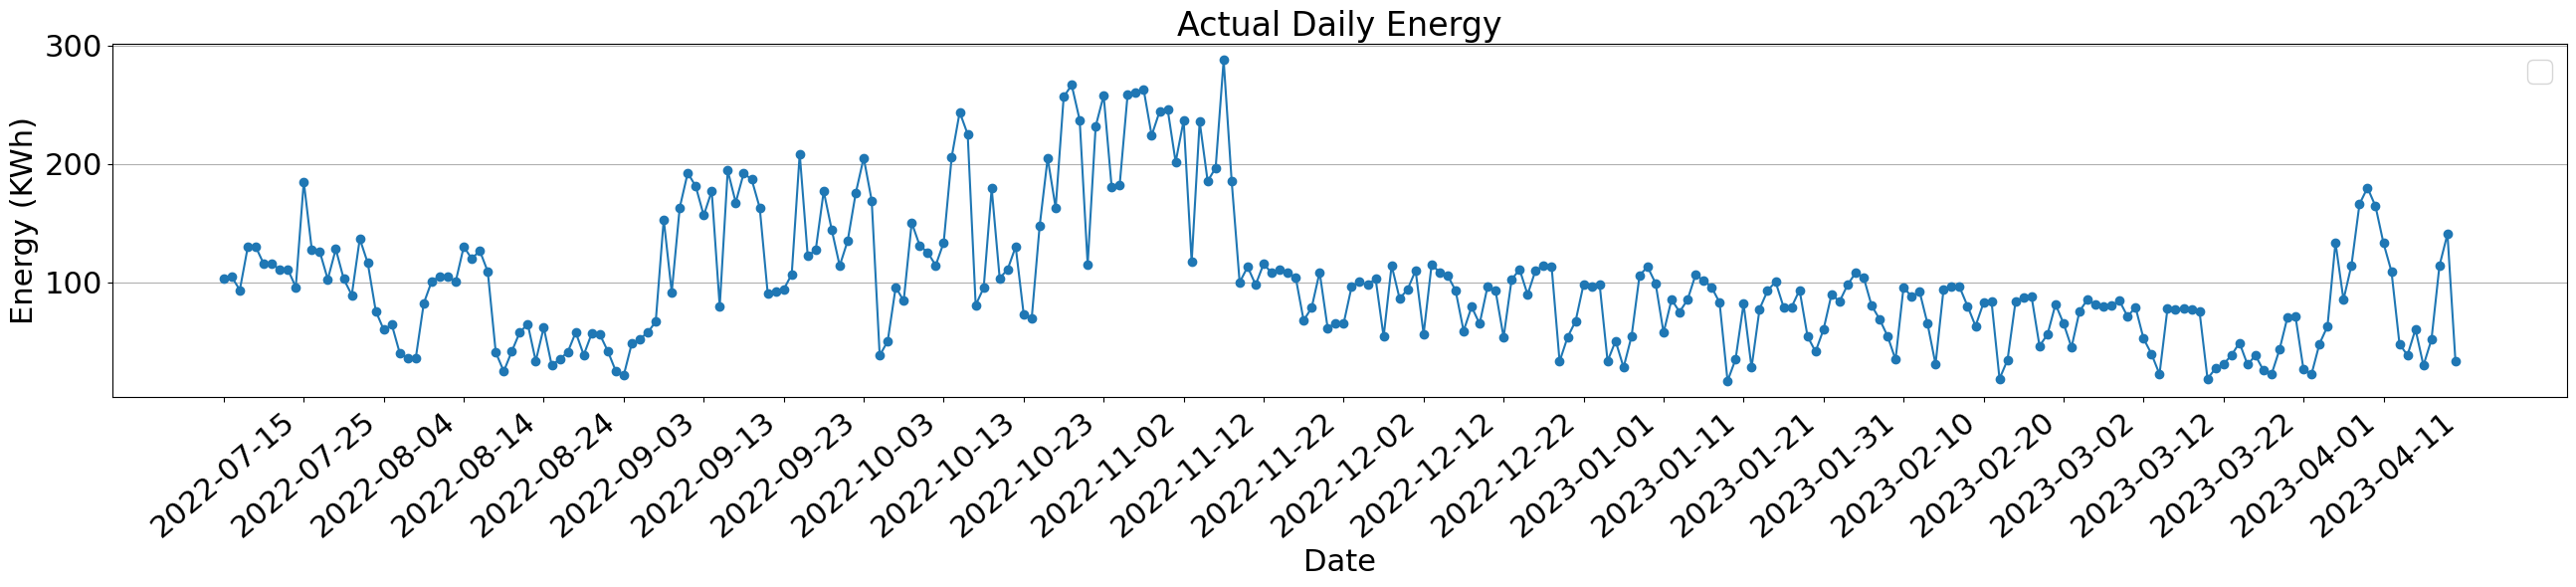

In [175]:
def plt_power(df_power_plt):
    fig, axes = plt.subplots(nrows=1,figsize=(26,6))
    
    axes.plot(df_power_plt['date'].values, df_power_plt['Focus_PV'].values, '-o')
    axes.legend(fontsize=22)
    axes.set_xlabel('Date', fontsize=22)
    axes.set_ylabel('Energy (KWh)', fontsize=22)
    axes.tick_params(axis='both', labelsize=22)
    axes.set_title('Actual Daily Energy', fontsize=24)
    axes.grid(axis='y')
    ticks, labels = plt.xticks()
    plt.xticks(ticks[::10], labels[::10])
    plt.xticks(rotation=40)
    fig.tight_layout()

plt_power(df_power_plt=df_peers_production)

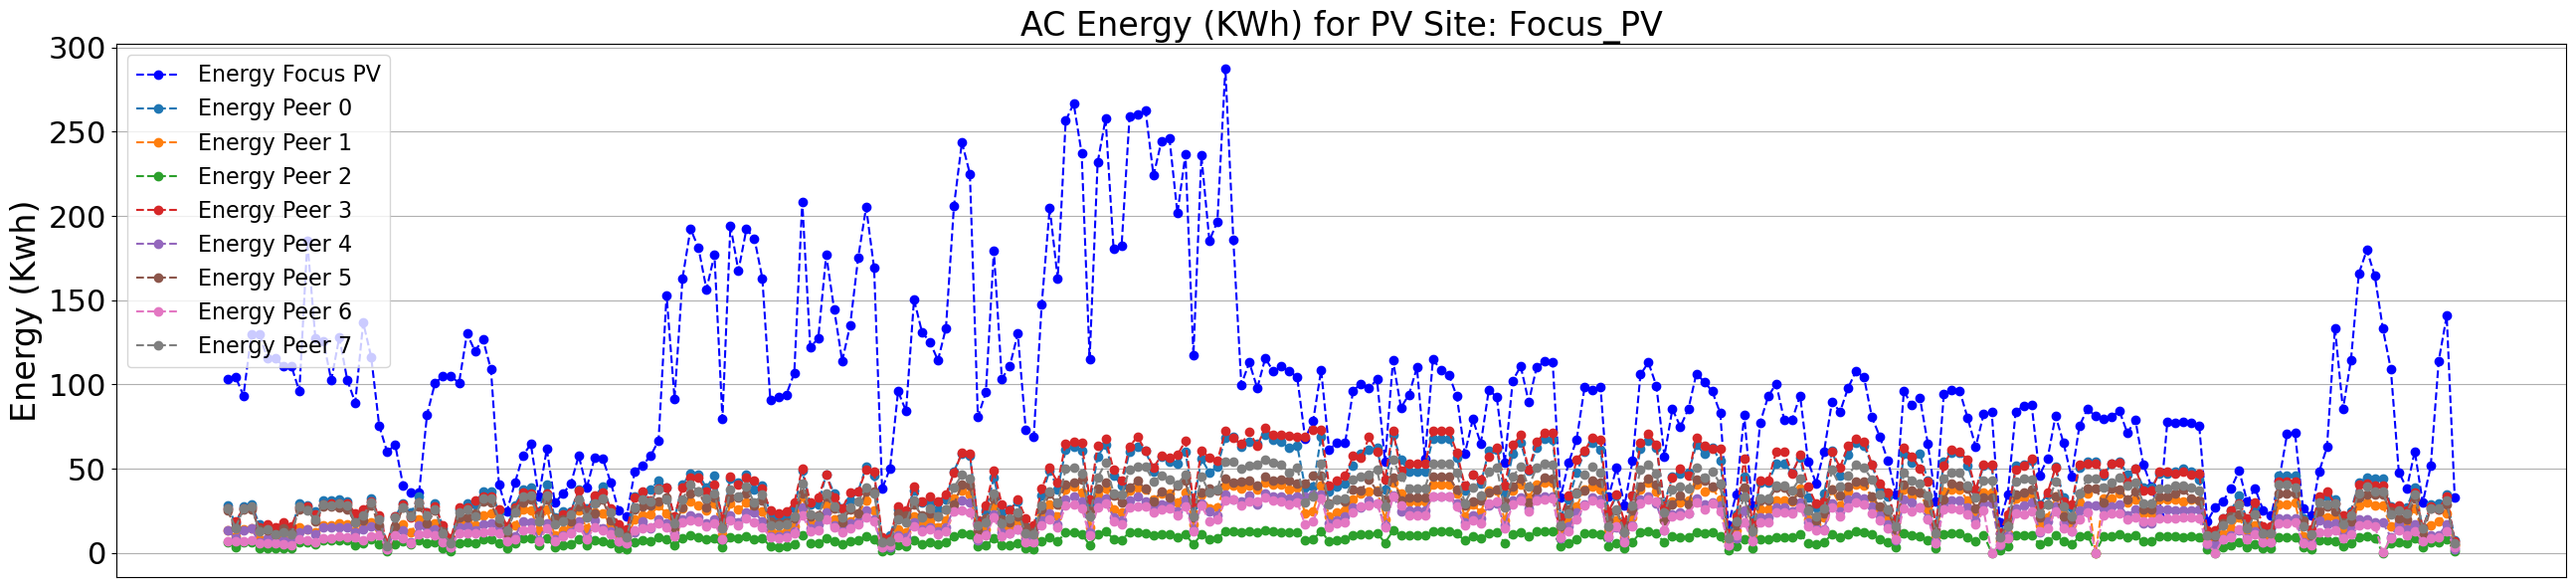

In [176]:
##===========================================================================================
## power plot of its peers
##===========================================================================================
def pltpower_peers(df_power, focus_pv, topsite_list):
    ## topsite_list is the list for top peers with higher weight factors
    fig, ax1 = plt.subplots(figsize=(26, 6))
    ax1.plot(df_power['date'], df_power[focus_pv], '--o', color='blue', label='Energy Focus PV')
    # ax1.plot(df_power['time'], df_power[topsite_list[0]], '--o', color='darkorange', label='Power biggest-weight PV')
    for j, site_id in enumerate(topsite_list):
        if j<=8 and site_id != focus_pv:
            ax1.plot(df_power['date'], df_power[site_id], '--o', label='Energy Peer {}'.format(j))
    ax1.legend(loc=2, fontsize=16)
    ax1.grid(axis='y')
    ax1.set_title('AC Energy (KWh) for PV Site: {}'.format(focus_pv), fontsize=24)
    ax1.tick_params(axis='both', labelsize=22)
    ax1.set_ylabel('Energy (Kwh)', fontsize=24)
    ax1.set_xticks([])
    # ticks, labels = plt.xticks()
    # plt.xticks(ticks[::10], labels[::10])
    # plt.xticks(rotation=40)
    fig.tight_layout()

pltpower_peers(df_power=df_peers_production, focus_pv='Focus_PV', topsite_list=df_peers_production.columns.to_list()[2:10])

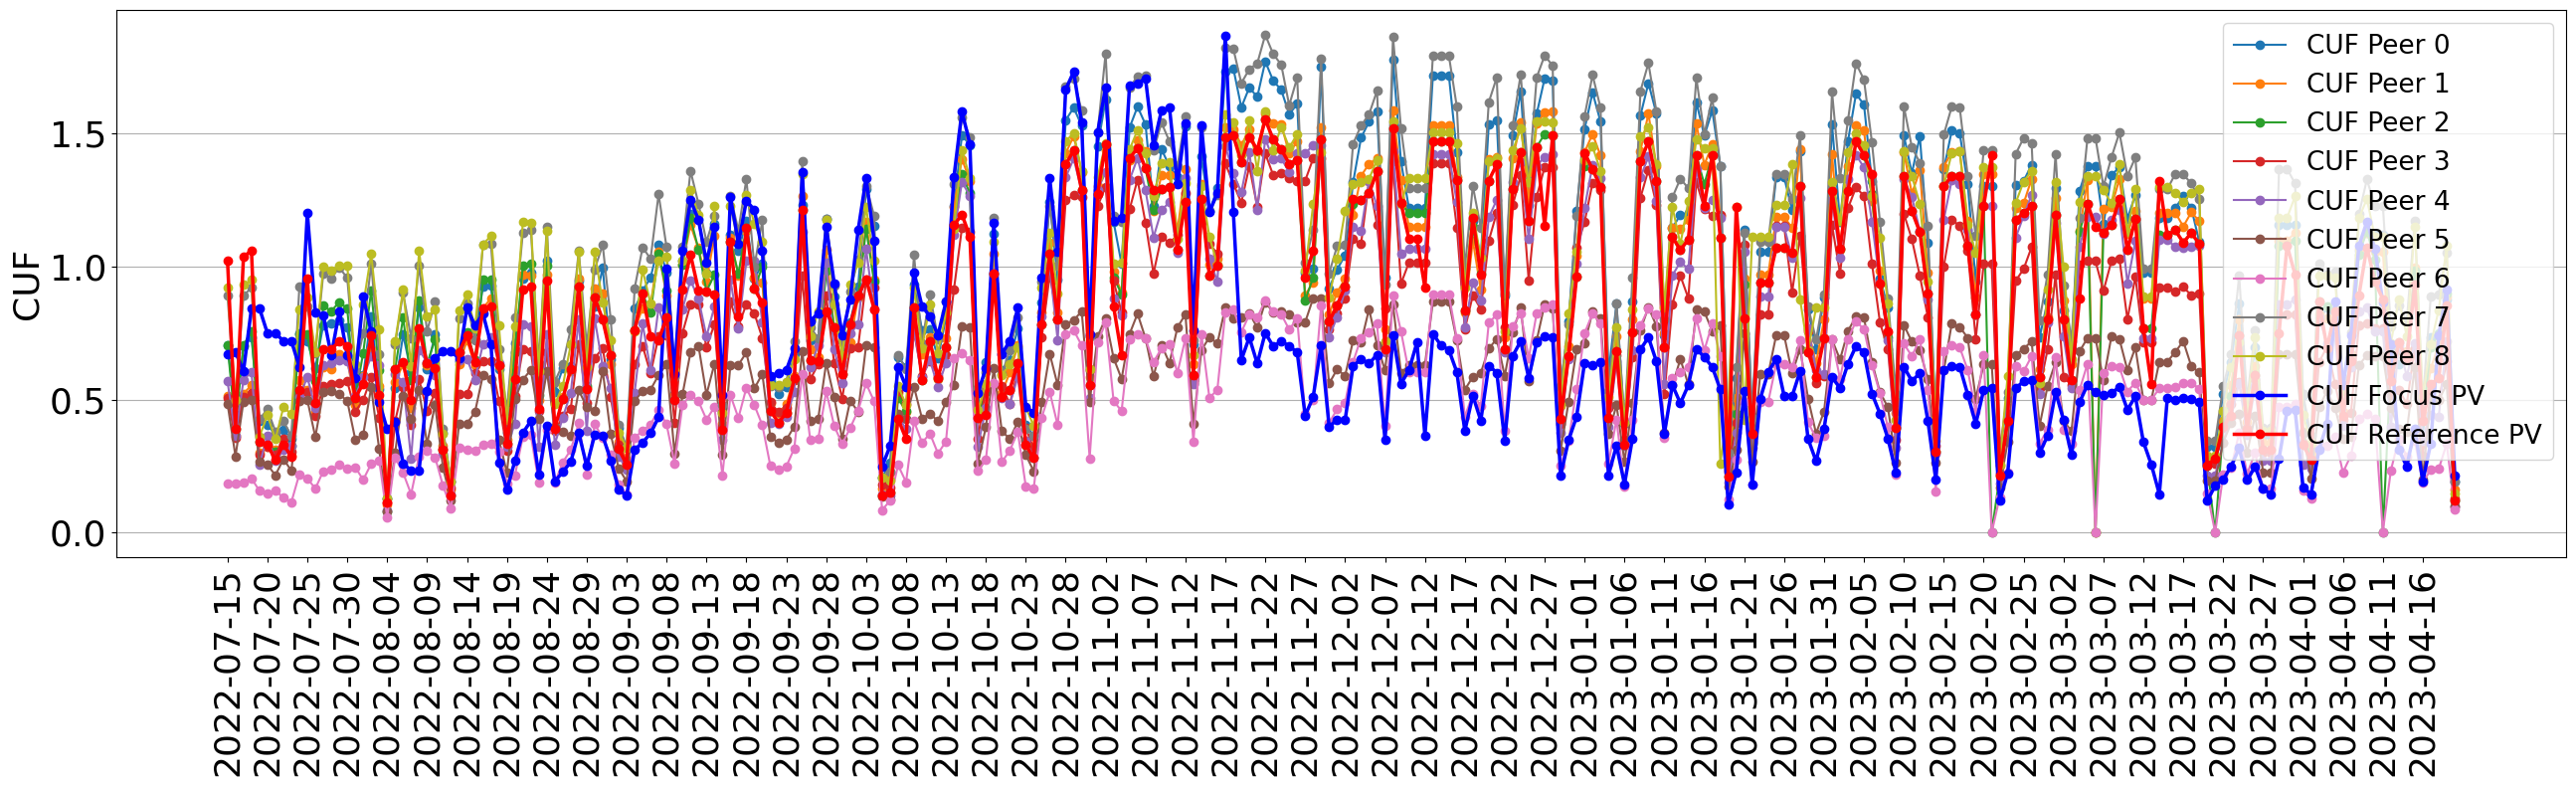

In [177]:
def pltcuf_peers(df_cuf, focus_pv, reference_MID, topsite_list):
    ## topsite_list is the list for top peers with higher weight factors
    fig, ax2 = plt.subplots(figsize=(26, 8))
    # ax2.plot(df_cuf['time'], df_cuf[topsite_list[0]], '-o', color='darkorange', label='CUF biggest-weight PV')
    for j, site_id in enumerate(topsite_list):
        if j<=8:
            ax2.plot(df_cuf['date'], df_cuf[site_id], '-o', label='CUF Peer {}'.format(j))
    ax2.plot(df_cuf['date'], df_cuf['Focus_PV'], '-o', color='blue', label='CUF Focus PV', lw=2.5)
    ax2.plot(df_cuf['date'], df_cuf[reference_MID], '-o', color='red', label='CUF Reference PV', lw=2.5)
    ax2.legend(loc=1, fontsize=19)
    # ax2.set_title('CUF for PV Site: {}'.format(focus_pv), fontsize=18)
    ax2.grid(axis='y')
    ax2.tick_params(axis='both', labelsize=26)
    ax2.set_ylabel('CUF', fontsize=26)
    # ax2.set_xticks([])
    ticks, labels = plt.xticks()
    plt.xticks(ticks[::5], labels[::5])
    plt.xticks(rotation=90)
    fig.tight_layout()

if window_num == 0:
    pltcuf_peers(df_cuf=df_cuf, focus_pv=focus_site_id_full, reference_MID='ref_cuf', topsite_list=effective_peers_window_list)



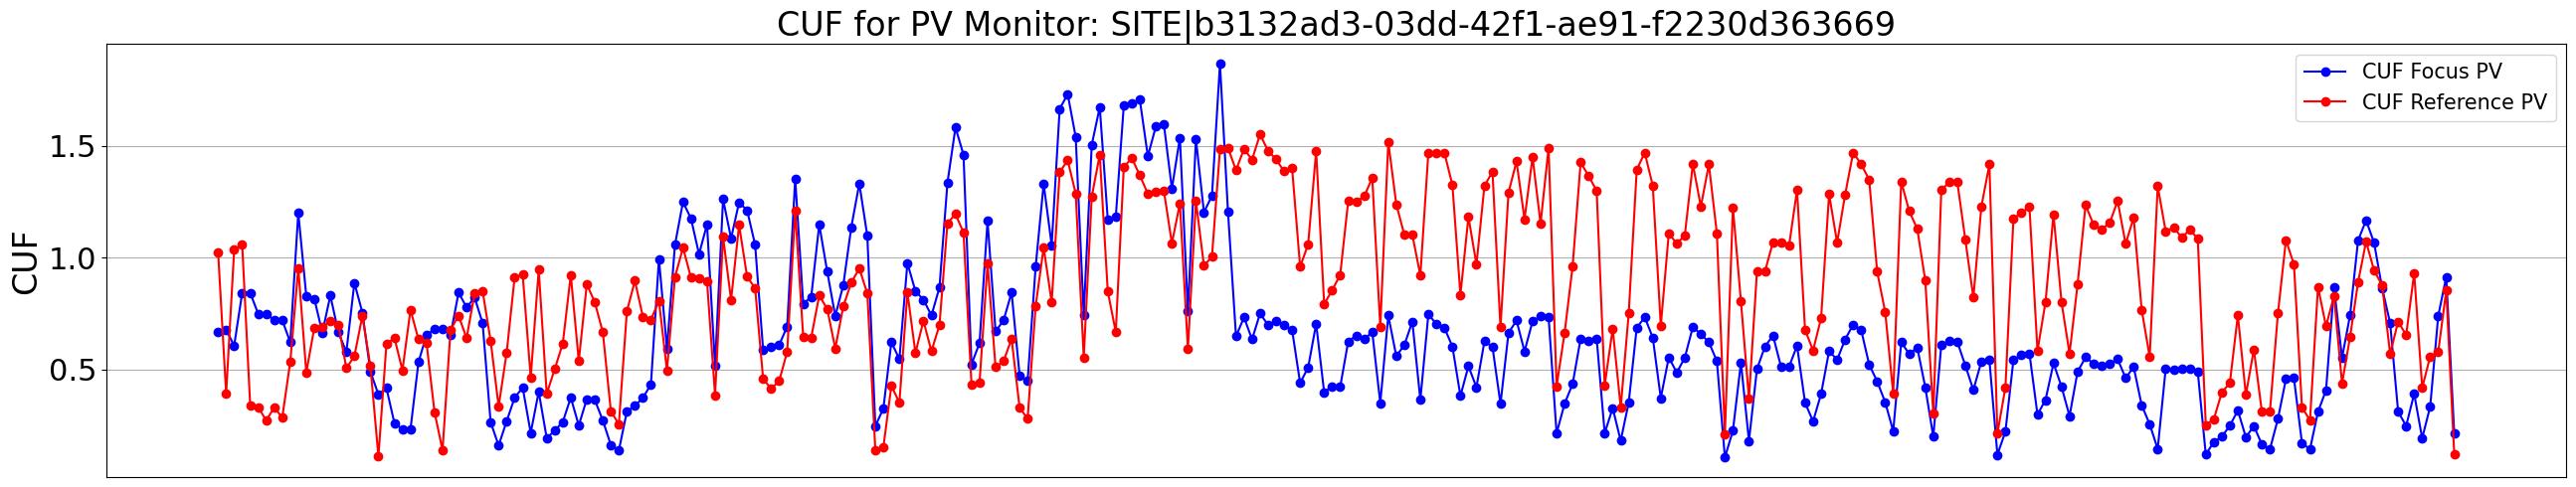

In [178]:
def pltcuf_peers(df_cuf, focus_pv, reference_MID):
    ## topsite_list is the list for top peers with higher weight factors
    fig, ax2 = plt.subplots(figsize=(26, 5))
    ax2.plot(df_cuf['date'], df_cuf['Focus_PV'], '-o', color='blue', label='CUF Focus PV')
    ax2.plot(df_cuf['date'], df_cuf[reference_MID], '-o', color='red', label='CUF Reference PV')
    ax2.legend(loc=1, fontsize=15)
    ax2.set_title('CUF for PV Monitor: {}'.format(focus_pv), fontsize=24)
    ax2.grid(axis='y')
    ax2.tick_params(axis='both', labelsize=22)
    ax2.set_ylabel('CUF', fontsize=24)
    ax2.set_xticks([])
    # ticks, labels = plt.xticks()
    # plt.xticks(ticks[::10], labels[::10])
    # plt.xticks(rotation=40)
    fig.tight_layout()
pltcuf_peers(df_cuf=df_p2p_pr, focus_pv=focus_site_id_full, reference_MID='ref_cuf')

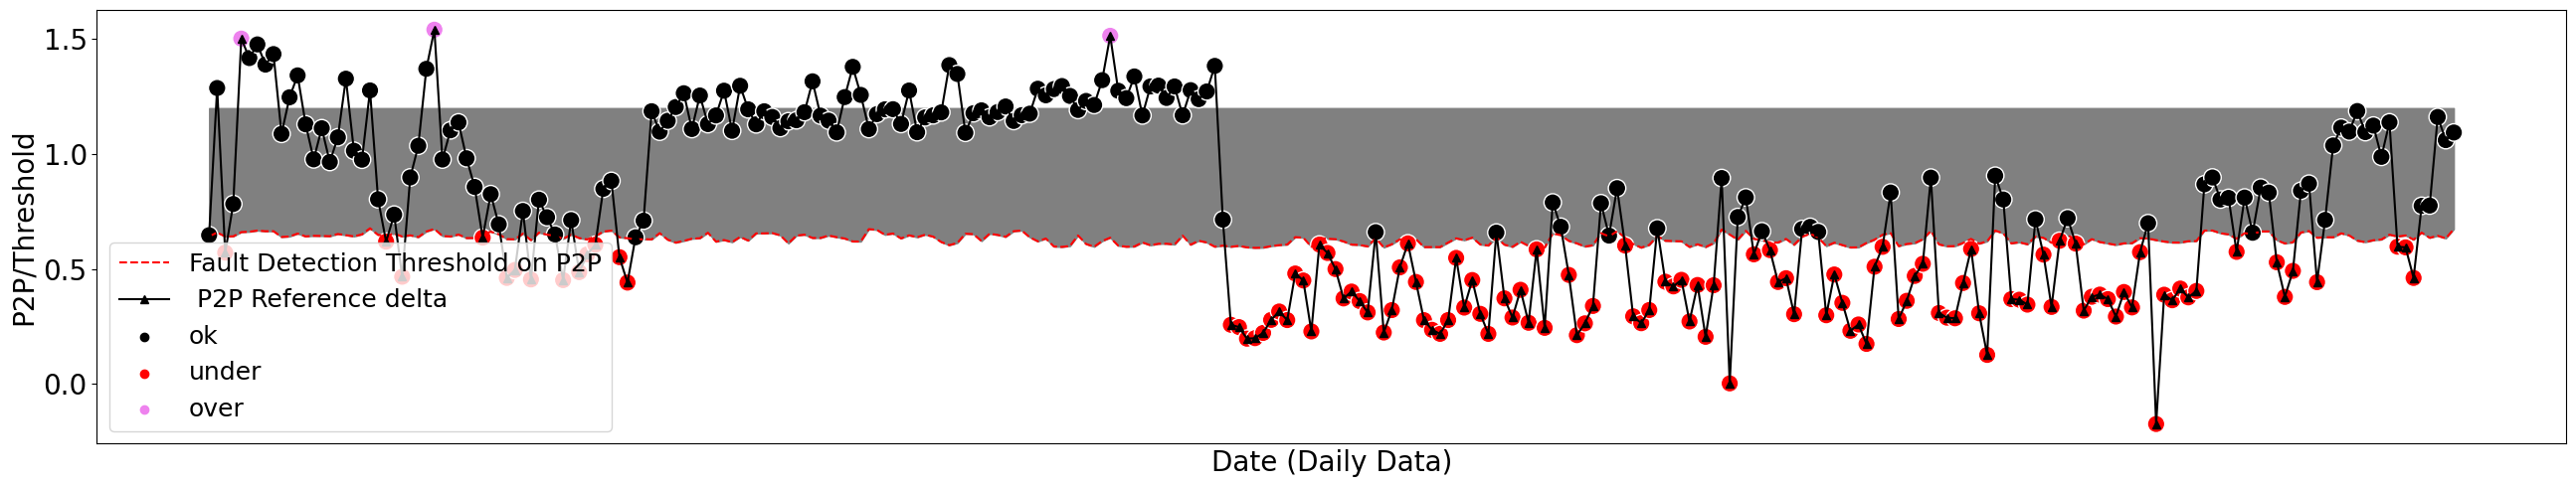

In [179]:
def plt_threshold_p2p(df_p2p, p2p_method):
    # calculate limitation bar of P2P with division method
    palette ={"ok": "black", "under": "red", "over": "violet", "medium": "darkorange"}
    fig, axe = plt.subplots(nrows=1, figsize=(26, 5))
    axe.plot(df_p2p['date'].values, df_p2p['thred_{}'.format(p2p_method)].values, '--', color='red', label='Fault Detection Threshold on P2P')
    axe.fill_between(df_p2p['date'].values, y1=1.2, y2=df_p2p['thred_{}'.format(p2p_method)].values, color='grey')
    axe.plot(df_p2p['date'].values, df_p2p['P2P_ref_{}'.format(p2p_method)].values, '-^', color='black', label=' P2P Reference {}'.format(p2p_method))
    sns.scatterplot(data = df_p2p, x='date', y='P2P_ref_{}'.format(p2p_method), hue='Performance_Label_P2P_{}'.format(p2p_method), 
                    palette=palette, markers='o', s=160, ax=axe)
    axe.legend(fontsize=18)
    axe.set_xlabel('Date (Daily Data)', fontsize=20)
    axe.set_ylabel('P2P/Threshold', fontsize=20)
    axe.tick_params(axis='both',  labelsize=20)
    axe.set_xticks([])


    # axe.plot(df_p2p['date'].values, df_p2p['Focus_PV'].values, '-o', color='blue', label='CUF Focus PV')
    # axe.plot(df_p2p['date'].values, df_p2p['ref_cuf'].values, '-o', color='red', label='CUF Reference')
    # axe[1].legend(fontsize=18)
    # axe[1].set_xlabel('Date (Daily Data)', fontsize=20)
    # axe[1].tick_params(axis='both',  labelsize=20)
    # axe[1].set_ylabel('CUF', fontsize=24)
    ticks, labels = plt.xticks()
    plt.xticks(ticks[::5], labels[::5])
    plt.xticks(rotation=90)
    fig.tight_layout()

plt_threshold_p2p(df_p2p=df_p2p_pr, p2p_method='delta')

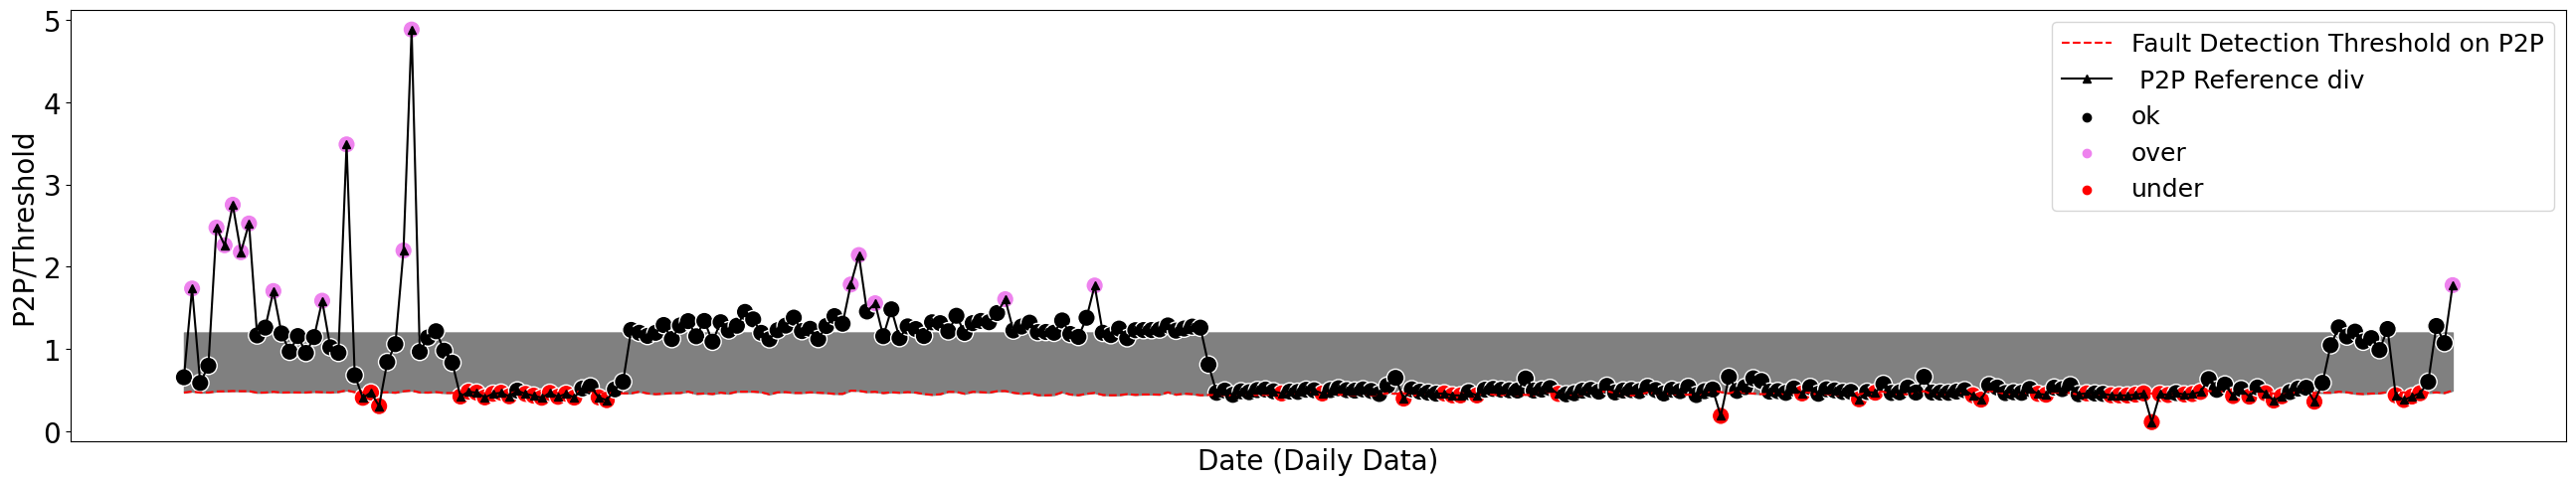

In [227]:
plt_threshold_p2p(df_p2p=df_p2p_pr, p2p_method='div')

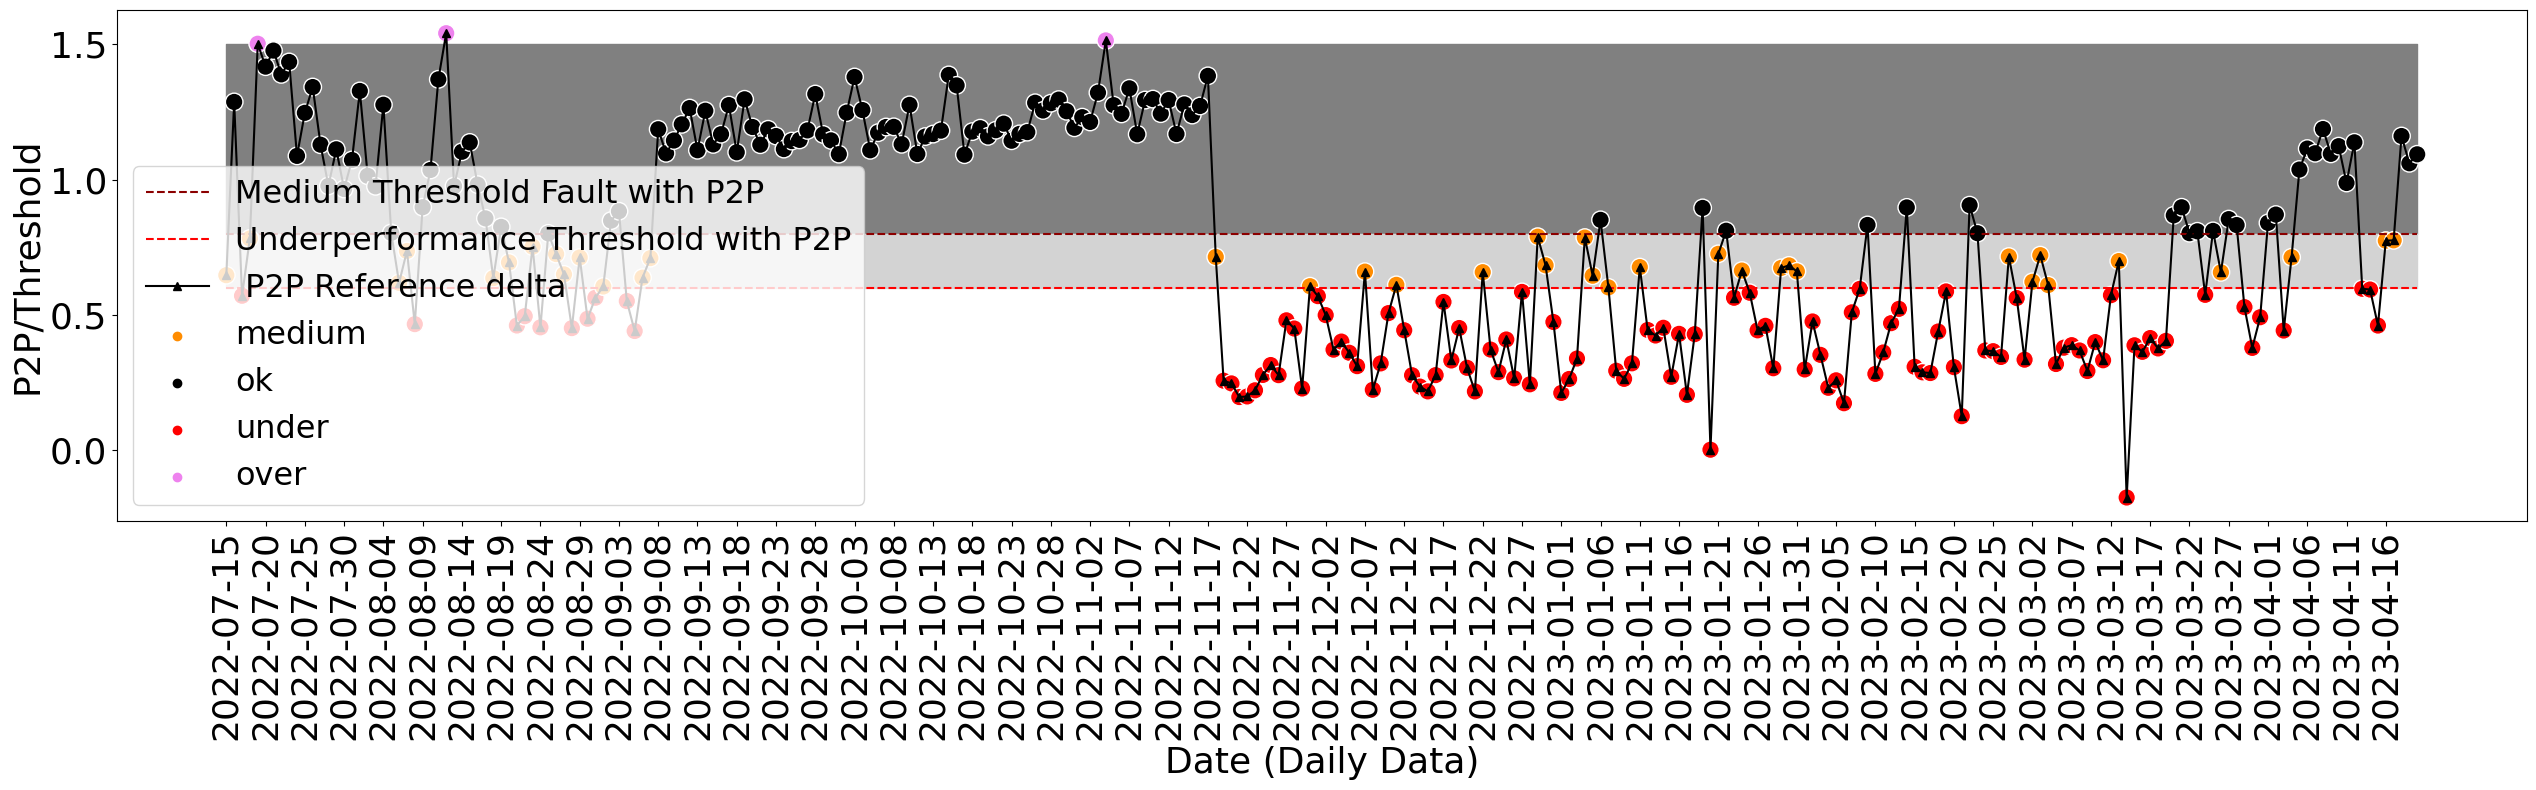

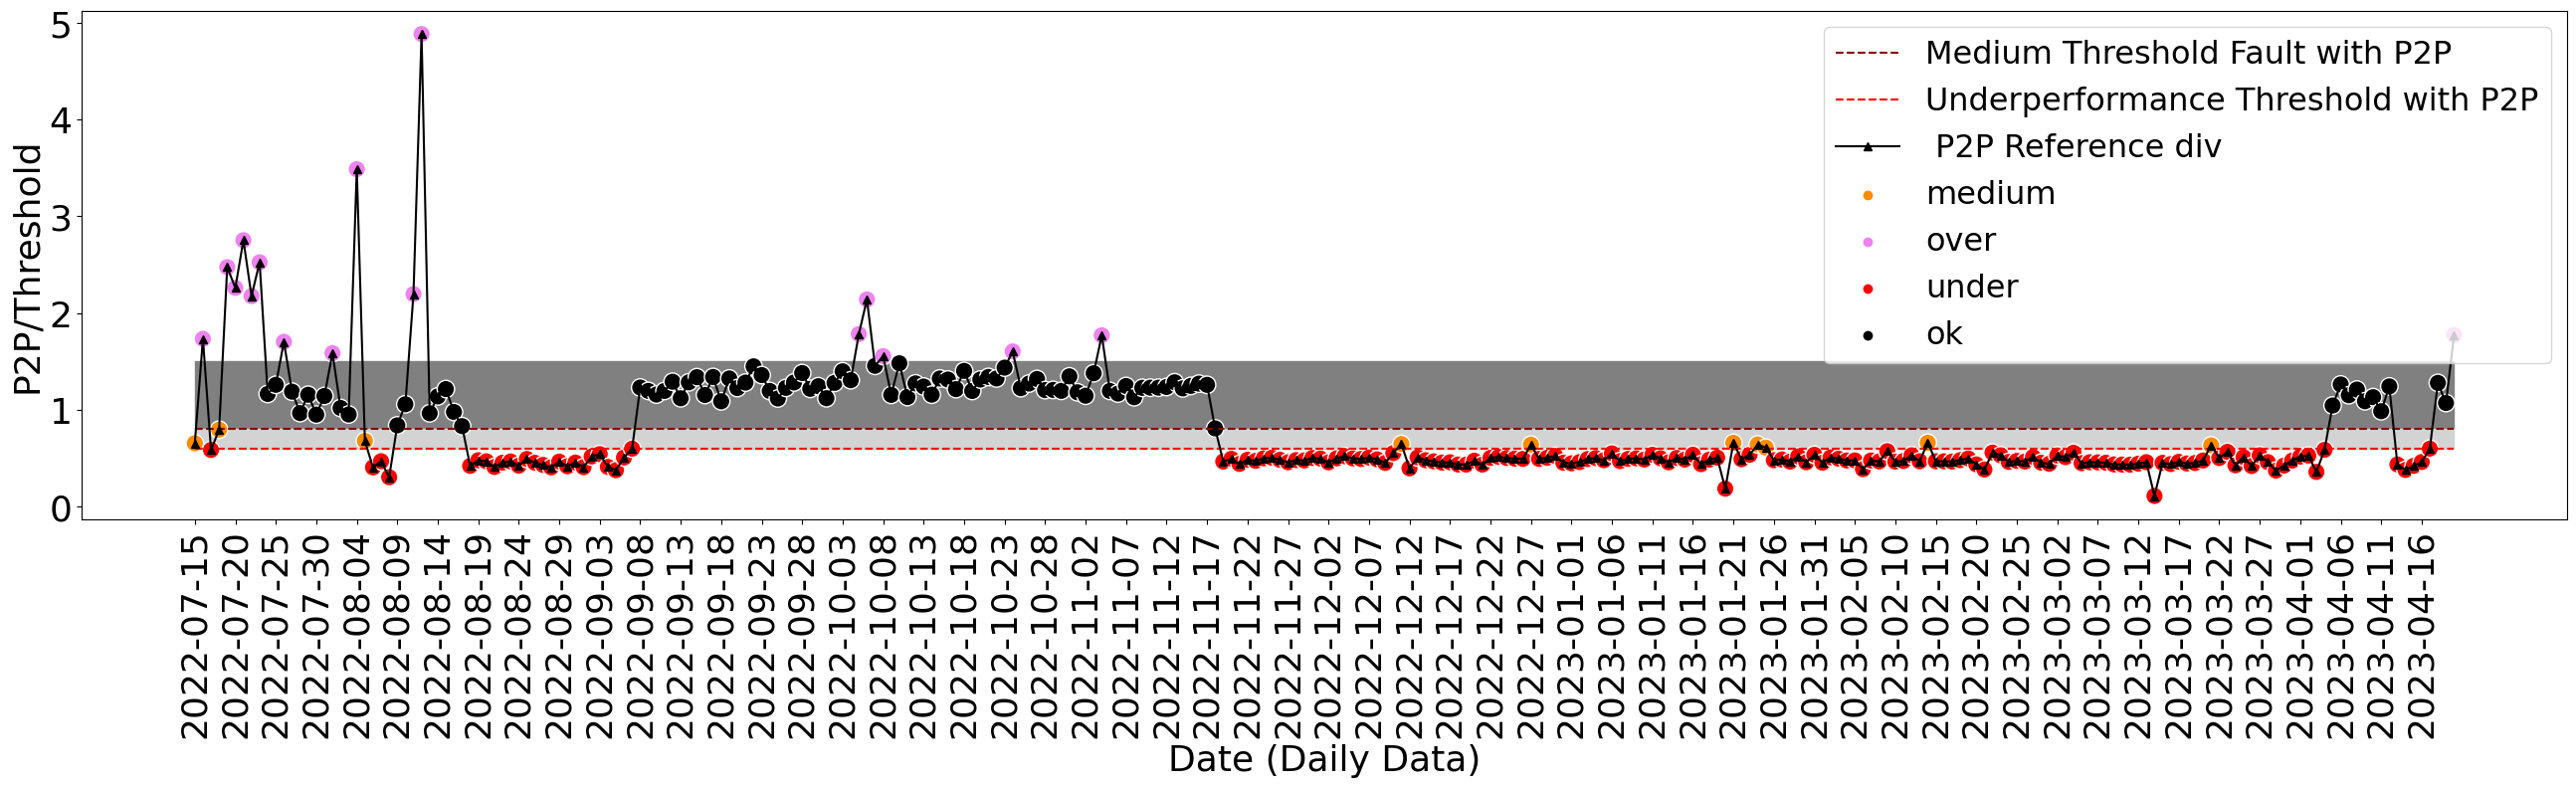

In [181]:
def plt_constant_p2p(df_p2p, p2p_method):
    # calculate limitation bar of P2P with division method
    palette ={"ok": "black", "under": "red", "over": "violet", "medium": "darkorange"}
    fig, axe = plt.subplots(nrows=1, figsize=(26, 8))
    axe.plot(df_p2p['date'].values, np.ones(len(df_p2p))*0.8, '--', color='darkred', label='Medium Threshold Fault with P2P')
    axe.fill_between(df_p2p['date'].values, y1=1.5, y2=0.8, color='grey')
    axe.plot(df_p2p['date'].values, np.ones(len(df_p2p))*0.6, '--', color='red', label='Underperformance Threshold with P2P')
    axe.fill_between(df_p2p['date'].values, y1=0.8, y2=np.ones(len(df_p2p))*0.6, color='lightgrey')
    axe.plot(df_p2p['date'].values, df_p2p['P2P_ref_{}'.format(p2p_method)].values, '-^', color='black', label=' P2P Reference {}'.format(p2p_method))
    sns.scatterplot(data = df_p2p, x='date', y='P2P_ref_{}'.format(p2p_method), hue='Perfomrnace_P2P_constant_{}'.format(p2p_method), 
                    palette=palette, markers='o', s=160, ax=axe)
    axe.legend(fontsize=23)
    axe.set_xlabel('Date (Daily Data)', fontsize=26)
    axe.set_ylabel('P2P/Threshold', fontsize=26)
    axe.tick_params(axis='both',  labelsize=26)
    # axe.set_xticks([])

    ticks, labels = plt.xticks()
    plt.xticks(ticks[::5], labels[::5])
    plt.xticks(rotation=90)
    fig.tight_layout()
    plt.savefig('p2p_long_term.pdf')
plt_constant_p2p(df_p2p=df_p2p_pr, p2p_method='delta')
plt_constant_p2p(df_p2p=df_p2p_pr, p2p_method='div')

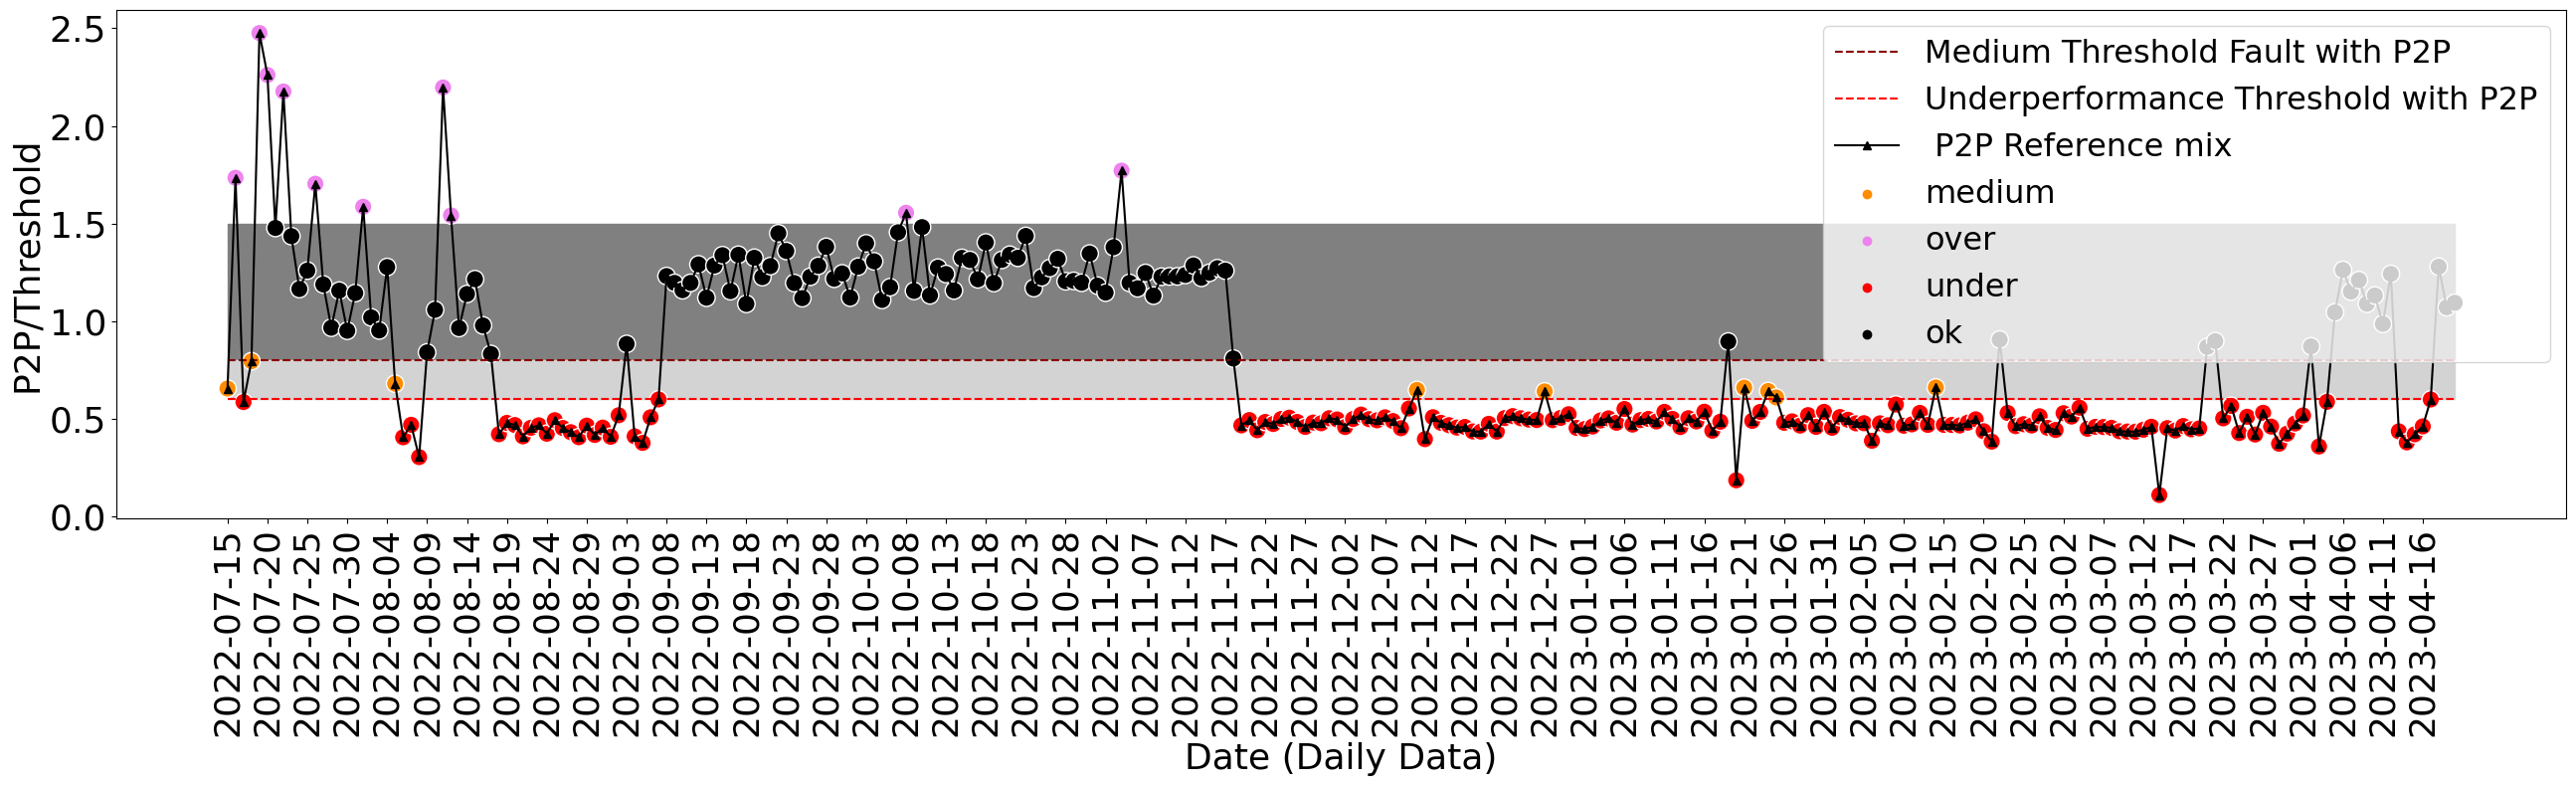

In [182]:
plt_constant_p2p(df_p2p=df_p2p_pr, p2p_method='mix')

In [183]:
df_p2p_pr.sort_values('date', inplace=True)

## 6.2 Compare between P2P and PR

In [184]:
def plt_pr_p2p(df_p2p, p2p_method, save_name):
    # calculate limitation bar of P2P with division method
    palette1 ={"ok": "black", "under": "red", "over": "violet", "medium": "darkorange"}
    palette2 ={"ok": "blue", "under": "darkred", "over": "violet", "medium": "green"}
    fig, axe = plt.subplots(nrows=1, figsize=(26, 8))
    axe.plot(df_p2p['date'].values, np.ones(len(df_p2p))*80, '--', color='darkred', label='Constant Threshold1 on P2P')
    axe.fill_between(df_p2p['date'].values, y1=120, y2=np.ones(len(df_p2p))*80, color='grey')
    axe.plot(df_p2p['date'].values, np.ones(len(df_p2p))*60, '--', color='red', label='Constant Threshold2 on P2P')
    axe.fill_between(df_p2p['date'].values, y1=80, y2=np.ones(len(df_p2p))*60, color='lightgrey')
    axe.plot(df_p2p['date'].values, df_p2p['P2P_ref_{}'.format(p2p_method)].values*100, '-o', color='black', 
             label=' P2P Reference {}'.format(p2p_method))
    sns.scatterplot(data = df_p2p, x=df_p2p['date'], y=df_p2p['P2P_ref_{}'.format(p2p_method)].values*100, 
                    hue='Perfomrnace_P2P_constant_{}'.format(p2p_method),palette=palette1, markers='o', s=160, ax=axe)

    # # plot pr
    sns.lineplot(data = df_p2p, x='date', y='Performance_Ratio(%).Daily', marker='X', color='darkblue', ax=axe, 
                 label='Performance Ratio (%)', lw=2)
    sns.scatterplot(data = df_p2p, x='date', y='Performance_Ratio(%).Daily', hue='Performance_Label_PR',
                    palette=palette2, markers='X', s=160, ax=axe)
    # sns.move_legend(axe, "upper left", bbox_to_anchor=(1.03, 1), fontsize=16)
    axe.legend(fontsize=22, bbox_to_anchor=(1.005, 1.01))
    axe.set_xlabel('Date (Daily Data)', fontsize=24)
    axe.set_ylabel('P2P(%)', fontsize=30)
    axe.tick_params(axis='both',  labelsize=26)
    ticks, labels = plt.xticks()
    plt.xticks(ticks[::5], labels[::5])
    plt.xticks(rotation=90)
    axe.grid(axis='y')
    
    fig.tight_layout()
    plt.savefig(save_name)



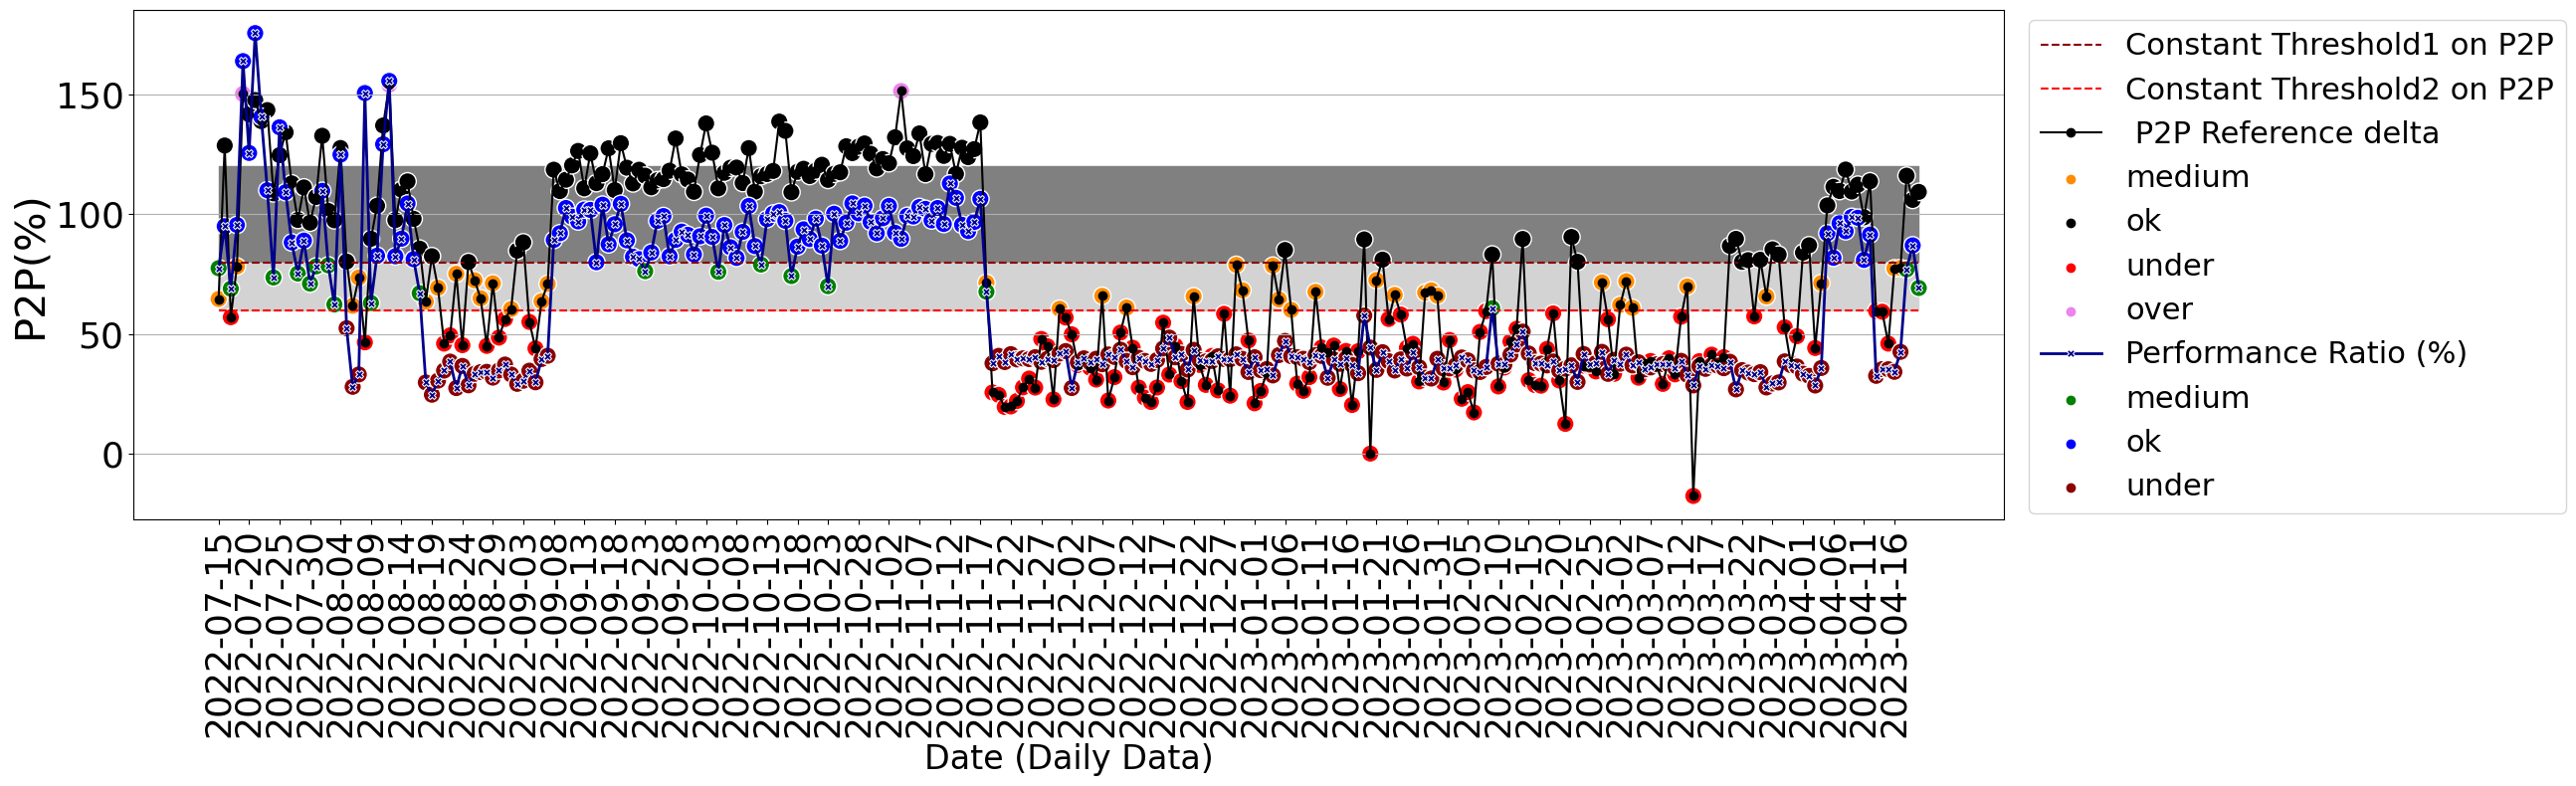

In [229]:
plt_pr_p2p(df_p2p=df_p2p_pr, p2p_method='delta', save_name='P2P_daily_delta.png')

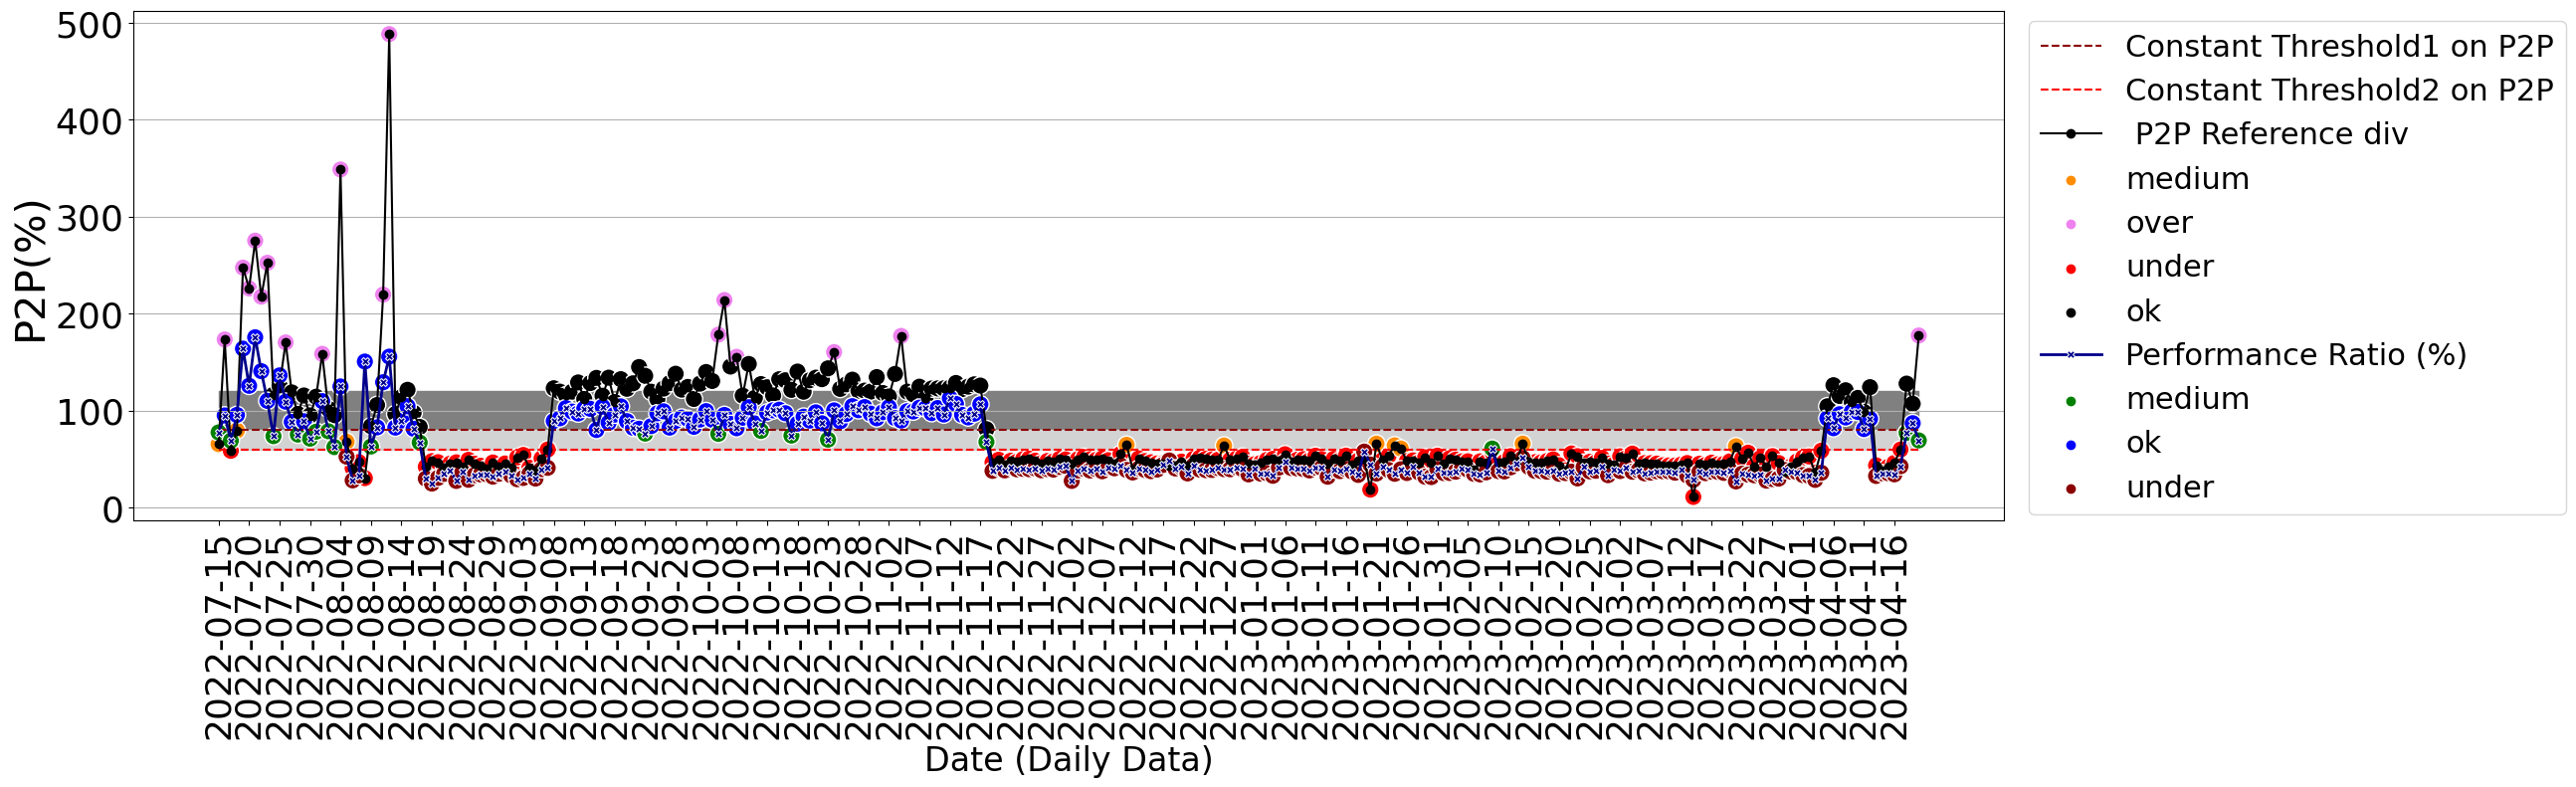

In [212]:
plt_pr_p2p(df_p2p=df_p2p_pr, p2p_method='div', save_name='P2P_daily_div.png')

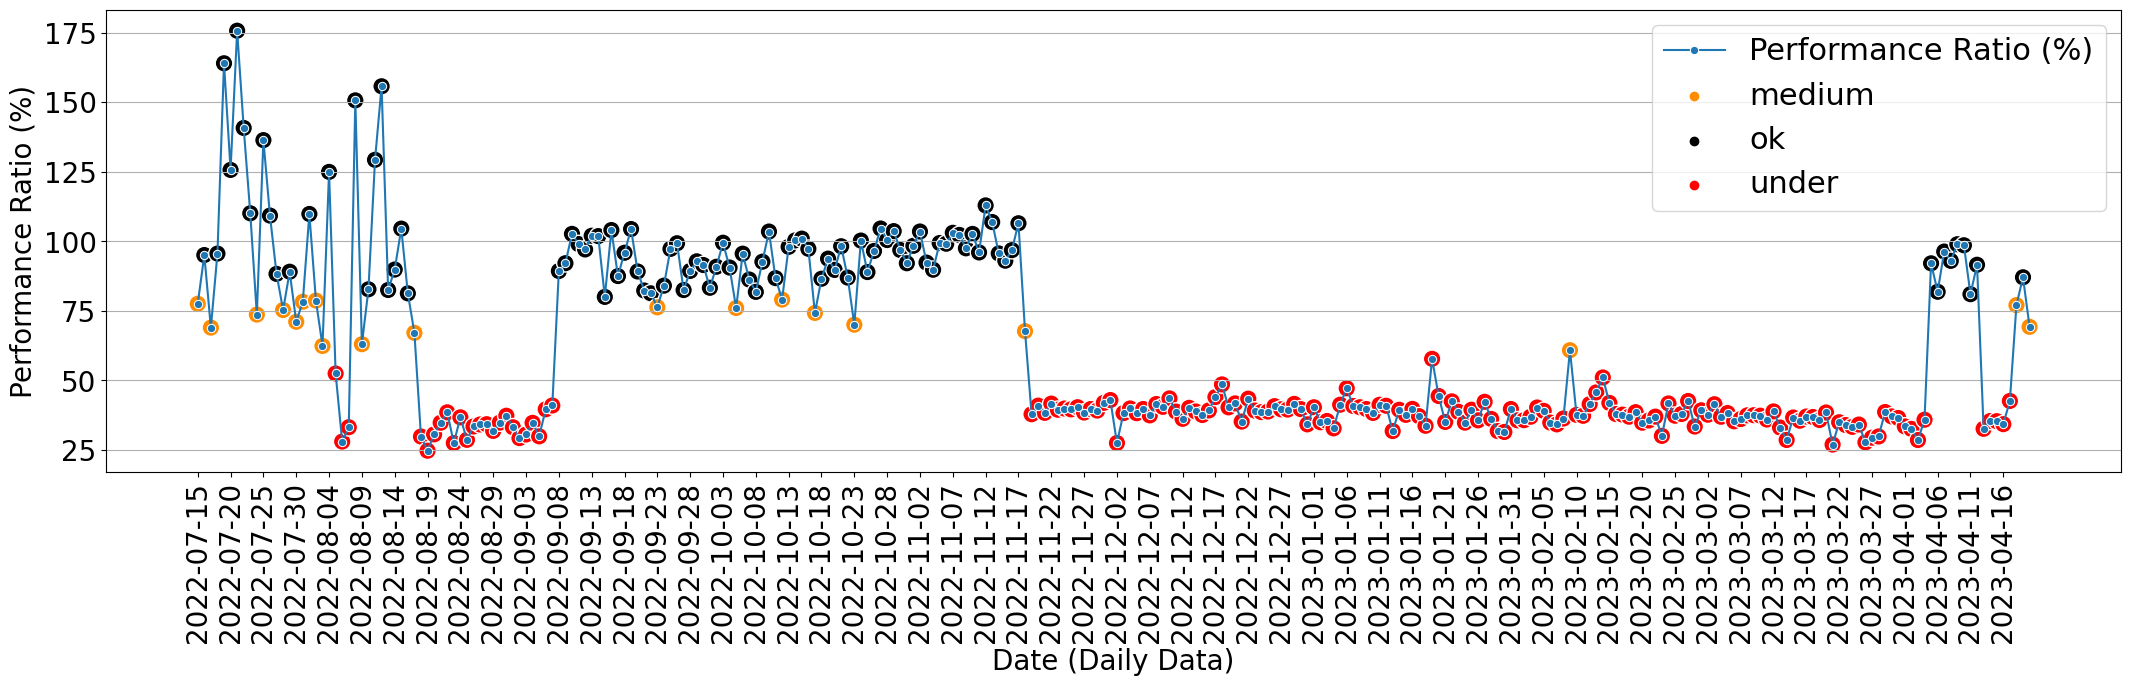

In [213]:
def plt_PR(df_pvmeasure):
    palette ={"ok": "black", "under": "red", "over": "violet", "medium": "darkorange"}
    fig, axe = plt.subplots(nrows=1, figsize=(26, 6))
    sns.lineplot(data = df_pvmeasure, x='date', y='Performance_Ratio(%).Daily', marker='o', sort = False, ax=axe, label='Performance Ratio (%)')
    sns.scatterplot(data = df_pvmeasure, x='date', y='Performance_Ratio(%).Daily', hue='Performance_Label_PR', palette=palette, markers='o', s=160, ax=axe)
    axe.legend(fontsize=22)
    axe.set_xlabel('Date (Daily Data)', fontsize=20)
    axe.set_ylabel('Performance Ratio (%)', fontsize=20)
    axe.tick_params(axis='both',  labelsize=20)
    ticks, labels = plt.xticks()
    plt.xticks(ticks[::5], labels[::5])
    plt.xticks(rotation=90)
    axe.grid(axis='y')
plt_PR(df_pvmeasure=df_p2p_pr)

In [214]:
df_p2p_pr

date  Focus_PV   ref_cuf  P2P_div_upperlimit  P2P_div_uppererror  \
0    2022-07-15  0.669897  1.023071            0.727545            0.072754   
1    2022-07-16  0.678748  0.391406            1.926808            0.192681   
2    2022-07-17  0.606399  1.035496            0.650680            0.065068   
3    2022-07-18  0.843101  1.060603            0.883251            0.088325   
4    2022-07-19  0.843101  0.340606            2.750331            0.275033   
..          ...       ...       ...                 ...                 ...   
275  2023-04-16  0.192874  0.418374            0.512232            0.051223   
276  2023-04-17  0.334722  0.558939            0.665392            0.066539   
277  2023-04-18  0.740157  0.578832            1.420787            0.142079   
278  2023-04-19  0.914049  0.853505            1.189929            0.118993   
279  2023-04-20  0.214669  0.120930            1.972397            0.197240   

     P2P_div_lowerlimit  P2P_div_lowererror  P2P_ref_div  P2P_ref_delta  \
0              0.595264            0.059526     0.654790       0.646826   
1              1.576480            0.157648     1.734128       1.287342   
2              0.532375            0.053237     0.585612       0.570903   
3              0.722660            0.072266     0.794926       0.782498   
4              2.250271            0.225027     2.475298       1.502495   
..                  ...                 ...          ...            ...   
275            0.419099            0.041910     0.461009       0.774500   
276            0.544412            0.054441     0.598853       0.775783   
277            1.162462            0.116246     1.278708       1.161325   
278            0.973578            0.097358     1.070936       1.060545   
279            1.613779            0.161378     1.775157       1.093740   

     thred_div  ...  Irrad.kWh.m2.Daily  is_low_cloudiness_day  \
0     0.468810  ...          133.029428                   True   
1     0.481624  ...          109.966491                   True   
2     0.468689  ...          135.359410                   True   
3     0.469283  ...          135.830289                   True   
4     0.482752  ...           84.438051                  False   
..         ...  ...                 ...                    ...   
275   0.481160  ...           86.598424                  False   
276   0.464655  ...          120.904264                  False   
277   0.471000  ...          147.905811                   True   
278   0.462826  ...          161.669772                   True   
279   0.492387  ...           47.717389                  False   

     Performance_Ratio(%).Daily Performance_Label_PR  \
0                     77.549821               medium   
1                     95.053729                   ok   
2                     68.990709               medium   
3                     95.588032                   ok   
4                    163.959453                   ok   
..                          ...                  ...   
275                   34.299219                under   
276                   42.634766                under   
277                   77.065431               medium   
278                   87.068585                   ok   
279                   69.280997               medium   

     Performance_Label_P2P_delta Perfomrnace_P2P_constant_delta  \
0                             ok                         medium   
1                             ok                             ok   
2                          under                          under   
3                             ok                         medium   
4                           over                           over   
..                           ...                            ...   
275                           ok                         medium   
276                           ok                         medium   
277                           ok                             ok   
278                      

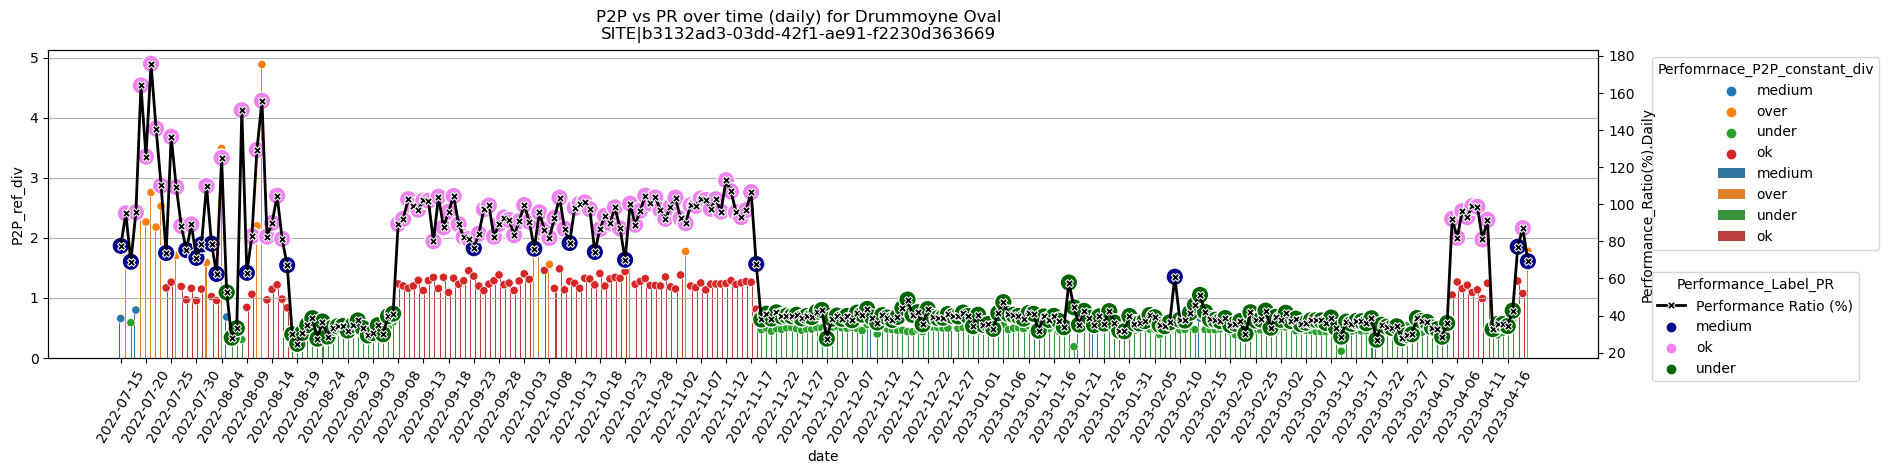

In [224]:
def plt_p2p_pr(df_p2p_pr):
    fig, ax1 = plt.subplots(nrows=1,figsize=(20, 4))
    plt.xticks(rotation=60)
    sns.barplot(data = df_p2p_pr, x='date', y='P2P_ref_div', ax=ax1, hue='Perfomrnace_P2P_constant_div')
    sns.scatterplot(data = df_p2p_pr, x='date', y='P2P_ref_div', ax=ax1, hue='Perfomrnace_P2P_constant_div')
    # plt.plot(df_p2p_pr['date'].values, np.ones(len(df_p2p_pr))*0.8, marker='x', color='red', label='threshold')
    ax2 = ax1.twinx()
    # palette ={"ok": "black", "under": "red", "over": "violet", "medium": "darkorange"}
    palette ={"ok": "violet", "under": "darkgreen", "over": "darkorgange", "medium": "darkblue"}
    sns.lineplot(data = df_p2p_pr, x='date', y='Performance_Ratio(%).Daily', marker='X', color='black', ax=ax2, 
                 label='Performance Ratio (%)', lw=2)
    sns.scatterplot(data = df_p2p_pr, x='date', y='Performance_Ratio(%).Daily', hue='Performance_Label_PR',
                    palette=palette, markers='X', s=160, ax=ax2)
    fig.suptitle('P2P vs PR over time (daily) for ' + str(site_name) + '\n' + str(focus_site_id_full))
    sns.move_legend(ax1, "upper left", bbox_to_anchor=(1.03, 1))
    sns.move_legend(ax2, "upper left", bbox_to_anchor=(1.03, 0.3))
    ticks, labels = plt.xticks()
    plt.xticks(ticks[::5], labels[::5])
    ax1.grid(axis='y')
    # figname = str(site_id + '.png')
    # fig.savefig('./plots/' + figname)
plt_p2p_pr(df_p2p_pr=df_p2p_pr)

# 7.  Check underperformance

In [190]:
window_size = 7
threshold_performance = -10
threshold_underperformance_days = 7
indicator_pr = 'Performance_Ratio(%).Daily'
indicator_p2p = 'P2P_ref_div'
if_clearsky_day = True

## 7.1. Functions

In [191]:
def get_rolling_average(df, window_size, indicator):
    df['SMA'] = df[indicator].rolling(window_size).mean()
    return df

def add_comparative (df, indicator):
    df['comparative'] = np.nan
    for i in range(len(df)):
        df['comparative'].iloc[i] = (df[indicator].iloc[i] - df['SMA'].iloc[i])
    return df

def underperformance_check(df, threshold, indicator):
    df['underperforming'] = np.nan
    for i in range(len(df)):
        # df["underperforming"].iloc[i] = df['comparative'].iloc[i] < threshold
        df["underperforming"].iloc[i] = df[indicator].iloc[i] < threshold
    return df

def rolling_underperformance(df):
    df['countUnder'] = np.nan
    # Rolling count of underperforming days:
    ix = pd.Series(range(df.shape[0])).where((~df['underperforming']).values, np.nan).ffill().values
    notna = pd.notna(ix)
    df["countUnder"] = df[notna].groupby(ix[notna]).cumcount()

    return df

In [192]:
# Updating SMA based on TRUE values of unpderforming
# def compare_underperfDay_with_SMA_of_under(df, indicator, days):
#     df['comparative_of_under'] = np.nan
#     df['SMA_before'] = df['SMA'].copy()
#     for i in range(len(df)):
#         df_previous_date = df.iloc[0:i, :]
#         df_previous_date = df_previous_date[df_previous_date['underperforming']==False]
#         total_len = len(df_previous_date)
#         df['SMA'][i] = df_previous_date[indicator][total_len-days:total_len].mean()
#         df['comparative_of_under'].iloc[i] = (df[indicator].iloc[i] - df['SMA'][i])
#     return df
def compare_underperfDay_with_SMA_of_under(df, indicator, days):
    df['comparative_of_under'] = np.nan
    df['SMA_BEFORE'] = df['SMA'].copy()
    steps_to_shift = 0
    for i in range(len(df)):
        if df['underperforming'][i] == True:
            steps_to_shift = steps_to_shift + 1
            df['comparative_of_under'].iloc[i] = (df[indicator].iloc[i] - df['SMA'].iloc[i-steps_to_shift])
            df['SMA'] = df['SMA'].iloc[i-steps_to_shift]
        else:
            steps_to_shift = 0
            df['comparative_of_under'].iloc[i] = (df[indicator].iloc[i] - df['SMA'].iloc[i])
    return df


def underperformance_check_of_under(df, threshold):
    df['underperforming_of_under'] = np.nan
    for i in range(len(df)):
        df["underperforming_of_under"].iloc[i] = df['comparative_of_under'].iloc[i] < threshold
    return df

def rolling_underperformance_of_under(df, days):
    df['countTrue_of_under'] = np.nan
    # Rolling count of underperforming days:
    ix = pd.Series(range(df.shape[0])).where((~df['underperforming_of_under']).values, np.nan).ffill().values
    notna = pd.notna(ix)
    df["countTrue_of_under"] = df[notna].groupby(ix[notna]).cumcount()
    return df

In [193]:
def retro_persistent_fault_check(df, days):
    dates_fault_started = []
    faulty_df = df[df['countTrue_of_under'] >= days]
    if not faulty_df.empty:
        dates_fault_started = faulty_df[faulty_df['countTrue_of_under'] == days]['date'].values
        for i, d in enumerate(dates_fault_started):
            fault_trdday_dex = faulty_df[faulty_df['date']==d].index
            fault_start_date = df['date'].iloc[fault_trdday_dex - days + 1].values[0]
            if len(dates_fault_started) == 0:
                count_fault = days-1 + faulty_df.count()[0]
            else:
                if i < len(dates_fault_started) - 1:
                    count_fault = days-1 + len(faulty_df[(faulty_df['date']<dates_fault_started[i+1])&(faulty_df['date']>=d)])
                else:
                    count_fault = days-1 + len(faulty_df[faulty_df['date']>=d])
            print(
                'Sudden and unresolved fault detected at '
                + site_name 
                +'\n' + 'SiteID: '
                + focus_site_id_full
                + '\nDates in which fault started are:' 
                + fault_start_date
                + '\nTotal days of fault = '
                +  str(count_fault)
                )
        # fault_details.append(site_id_full, site_name, sudden_unresolved, count_fault, faulty_df, dates_fault_started)
        # fault_sites.append(focus_site_id_full)
        # return focus_site_id_full, site_name, sudden_unresolved, count_fault, faulty_df, dates_fault_started
    else:
        sudden_unresolved = False
        print("No long persistant faults detected at " + site_name)

## 7.2. PR-Based Performance

In [194]:
df_pr_check = df_p2p_pr.copy()
df_pr_check = df_pr_check[['date', 'Focus_PV', measure_name_expect, 'is_low_cloudiness_day', 'Performance_Ratio(%).Daily', 'Performance_Label_PR']]
if if_clearsky_day is True:
    df_pr_check = df_pr_check[df_pr_check['is_low_cloudiness_day']==True]
    df_pr_check.index = np.arange(len(df_pr_check))
df_pr_check

date  Focus_PV  Irrad.kWh.m2.Daily is_low_cloudiness_day  \
0    2022-07-15  0.669897          133.029428                  True   
1    2022-07-16  0.678748          109.966491                  True   
2    2022-07-17  0.606399          135.359410                  True   
3    2022-07-18  0.843101          135.830289                  True   
4    2022-07-24  0.622611          130.136133                  True   
..          ...       ...                 ...                   ...   
135  2023-04-10  1.066958          166.681535                  True   
136  2023-04-11  0.864366          164.346122                  True   
137  2023-04-15  0.391668          170.542781                  True   
138  2023-04-18  0.740157          147.905811                  True   
139  2023-04-19  0.914049          161.669772                  True   

     Performance_Ratio(%).Daily Performance_Label_PR  
0                     77.549821               medium  
1                     95.053729                   ok  
2                     68.990709               medium  
3                     95.588032                   ok  
4                     73.678359               medium  
..                          ...                  ...  
135                   98.578106                   ok  
136                   80.995168                   ok  
137                   35.367568                under  
138                   77.065431               medium  
139                   87.068585                   ok  

[140 rows x 6 columns]

In [195]:
df_pr_check = get_rolling_average(df=df_pr_check, window_size=window_size, indicator=indicator_pr)
# df_pr_check = add_comparative(df=df_pr_check, indicator=indicator_pr)
df_pr_check = underperformance_check(df_pr_check, indicator=indicator_pr, threshold=60)
df_pr_check = rolling_underperformance(df_pr_check)
df_pr_check.iloc[15:35, :]

date  Focus_PV  Irrad.kWh.m2.Daily is_low_cloudiness_day  \
15  2022-08-09  0.533410          130.337889                  True   
16  2022-08-14  0.844708          144.781756                  True   
17  2022-08-16  0.822576          155.833175                  True   
18  2022-08-17  0.707921          162.447157                  True   
19  2022-08-18  0.264548          136.460013                  True   
20  2022-08-21  0.374780          165.765520                  True   
21  2022-08-22  0.419397          167.533884                  True   
22  2022-08-24  0.400944          167.997721                  True   
23  2022-08-28  0.374640          168.280875                  True   
24  2022-08-30  0.368127          162.603990                  True   
25  2022-08-31  0.364174          150.249855                  True   
26  2022-09-05  0.337863          173.850715                  True   
27  2022-09-07  0.433311          162.729016                  True   
28  2022-09-08  0.993908          171.372897                  True   
29  2022-09-11  1.249420          194.364996                  True   
30  2022-09-12  1.175485          186.495617                  True   
31  2022-09-14  1.149388          173.773784                  True   
32  2022-09-16  1.262223          186.843116                  True   
33  2022-09-17  1.086962          191.288038                  True   
34  2022-09-18  1.247885          200.414770                  True   

    Performance_Ratio(%).Daily Performance_Label_PR        SMA  \
15                   63.024747               medium  71.737792   
16                   89.849085                   ok  71.849861   
17                   81.289976                   ok  73.307201   
18                   67.110952               medium  67.206100   
19                   29.855144                under  60.226207   
20                   34.817957                under  56.285805   
21                   38.551704                under  57.785652   
22                   36.753723                under  54.032649   
23                   34.284694                under  46.094878   
24                   34.864817                under  39.462713   
25                   37.326381                under  35.207774   
26                   29.928479                under  35.218251   
27                   41.006772                under  36.102367   
28                   89.315076                   ok  43.354277   
29                   98.994505                   ok  52.245818   
30                   97.066490                   ok  61.214646   
31                  101.859869                   ok  70.785368   
32                  104.035052                   ok  80.315178   
33                   87.507868                   ok  88.540805   
34                   95.888308                   ok  96.381024   

   underperforming  countUnder  
15           False           0  
16           False           0  
17           False           0  
18           False           0  
19            True           1  
20            True           2  
21            True           3  
22            True           4  
23            True           5  
24            True           6  
25            True           7  
26            True           8  
27            True           9  
28           False           0  
29           False           0  
30           False           0  
31           False           0  
32           False           0  
33           False           0  
34           False           0

In [196]:
df_pr_check["underperforming"].info

<bound method Series.info of 0      False
1      False
2      False
3      False
4      False
       ...  
135    False
136    False
137     True
138    False
139    False
Name: underperforming, Length: 140, dtype: object>

In [197]:
# Analysis on days that underperformed, excluding such days from the rolling average:
df_pr_check = compare_underperfDay_with_SMA_of_under(df_pr_check, indicator=indicator_pr, days=threshold_underperformance_days)
df_pr_check = underperformance_check_of_under(df_pr_check, threshold_performance)
df_pr_check = rolling_underperformance_of_under(df_pr_check, threshold_underperformance_days)
df_pr_check.iloc[16:36, :]
# df_pr_check.iloc[55:75, :]

date  Focus_PV  Irrad.kWh.m2.Daily is_low_cloudiness_day  \
16  2022-08-14  0.844708          144.781756                  True   
17  2022-08-16  0.822576          155.833175                  True   
18  2022-08-17  0.707921          162.447157                  True   
19  2022-08-18  0.264548          136.460013                  True   
20  2022-08-21  0.374780          165.765520                  True   
21  2022-08-22  0.419397          167.533884                  True   
22  2022-08-24  0.400944          167.997721                  True   
23  2022-08-28  0.374640          168.280875                  True   
24  2022-08-30  0.368127          162.603990                  True   
25  2022-08-31  0.364174          150.249855                  True   
26  2022-09-05  0.337863          173.850715                  True   
27  2022-09-07  0.433311          162.729016                  True   
28  2022-09-08  0.993908          171.372897                  True   
29  2022-09-11  1.249420          194.364996                  True   
30  2022-09-12  1.175485          186.495617                  True   
31  2022-09-14  1.149388          173.773784                  True   
32  2022-09-16  1.262223          186.843116                  True   
33  2022-09-17  1.086962          191.288038                  True   
34  2022-09-18  1.247885          200.414770                  True   
35  2022-09-19  1.212666          178.879541                  True   

    Performance_Ratio(%).Daily Performance_Label_PR        SMA  \
16                   89.849085                   ok  82.097517   
17                   81.289976                   ok  82.097517   
18                   67.110952               medium  82.097517   
19                   29.855144                under  82.097517   
20                   34.817957                under  82.097517   
21                   38.551704                under  82.097517   
22                   36.753723                under  82.097517   
23                   34.284694                under  82.097517   
24                   34.864817                under  82.097517   
25                   37.326381                under  82.097517   
26                   29.928479                under  82.097517   
27                   41.006772                under  82.097517   
28                   89.315076                   ok  82.097517   
29                   98.994505                   ok  82.097517   
30                   97.066490                   ok  82.097517   
31                  101.859869                   ok  82.097517   
32                  104.035052                   ok  82.097517   
33                   87.507868                   ok  82.097517   
34                   95.888308                   ok  82.097517   
35                  104.400192                   ok  82.097517   

   underperforming  countUnder  comparative_of_under  SMA_BEFORE  \
16           False           0              7.751568   71.849861   
17           False           0             -0.807541   73.307201   
18           False           0            -14.986565   67.206100   
19            True           1            -52.242373   60.226207   
20            True           2            -47.279560   56.285805   
21            True           3            -43.545813   57.785652   
22            True           4            -45.343794   54.032649   
23            True           5            -47.812823   46.094878   
24            True           6            -47.232700   39.462713   
25            True           7            -44.771136   35.207774   
26            True           8            -52.169038   35.218251   
27            True           9            -41.090745   36.102367   
28           False           0              7.217559   43.354277   
29           False           0             16.896988   52.245818   
30           False           0             14.968974   61.214646   
31           False           0             19.762353   70.785368

In [198]:
# To retroactively check if there was fault:
retro_persistent_fault_check(df_pr_check, threshold_underperformance_days)

Sudden and unresolved fault detected at Drummoyne Oval
SiteID: SITE|b3132ad3-03dd-42f1-ae91-f2230d363669
Dates in which fault started are:2022-08-17
Total days of fault = 10
Sudden and unresolved fault detected at Drummoyne Oval
SiteID: SITE|b3132ad3-03dd-42f1-ae91-f2230d363669
Dates in which fault started are:2022-11-18
Total days of fault = 76


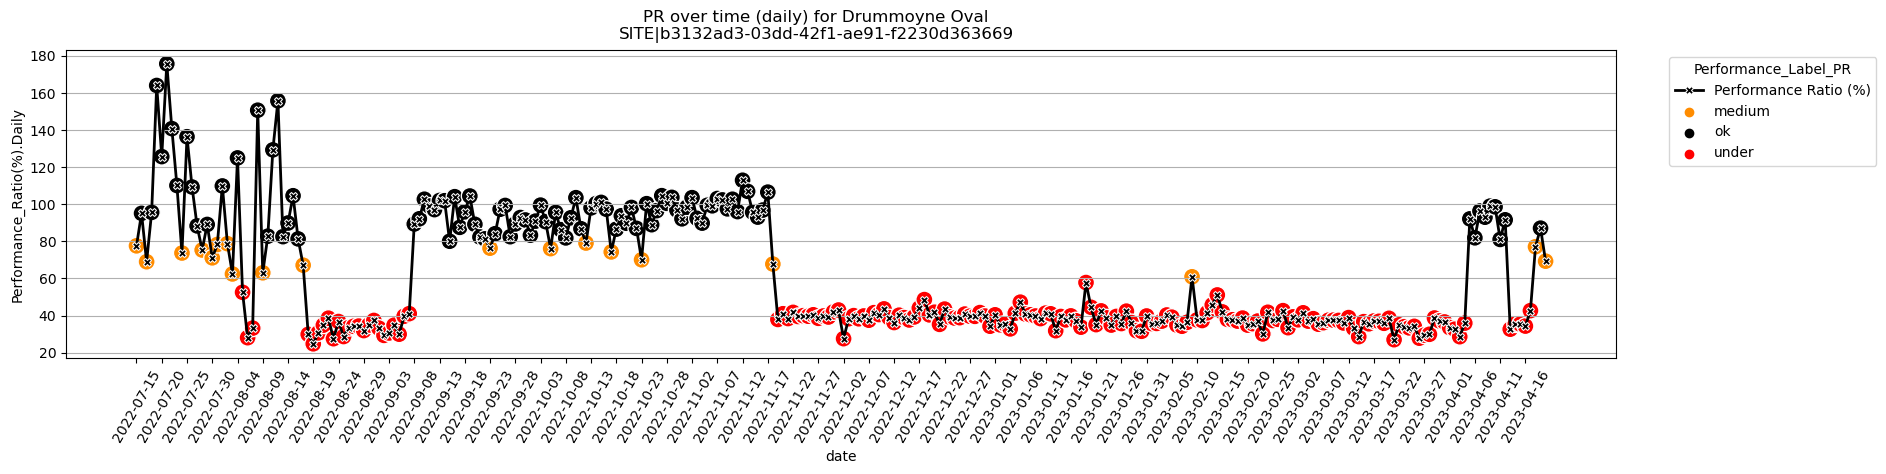

In [222]:
def plt_pr_check(df):
    fig, ax1 = plt.subplots(nrows=1,figsize=(20, 4))
    plt.xticks(rotation=60)
    palette ={"ok": "black", "under": "red", "over": "violet", "medium": "darkorange"}
    sns.lineplot(data = df_p2p_pr, x='date', y='Performance_Ratio(%).Daily', marker='X', color='black', ax=ax1, 
                 label='Performance Ratio (%)', lw=2)
    sns.scatterplot(data = df_p2p_pr, x='date', y='Performance_Ratio(%).Daily', hue='Performance_Label_PR',
                    palette=palette, markers='X', s=150, ax=ax1)
    fig.suptitle('PR over time (daily) for ' + str(site_name) + '\n' + str(focus_site_id_full))
    sns.move_legend(ax1, "upper left", bbox_to_anchor=(1.03, 1))
    ticks, labels = plt.xticks()
    plt.xticks(ticks[::5], labels[::5])
    ax1.grid(axis='y')
    # figname = str(site_id + '.png')
    # fig.savefig('./plots/' + figname)
plt_pr_check(df_pr_check)

## 7.3. P2P-Based Performance

In [200]:
df_p2p_check = df_p2p_pr.copy()
df_p2p_check = df_p2p_check[['date', 'Focus_PV', 'ref_cuf', 'P2P_ref_div', 'P2P_ref_delta', 'is_low_cloudiness_day']]
df_p2p_check['P2P_ref_div'] = df_p2p_check['P2P_ref_div'].astype(float)*100
df_p2p_check['P2P_ref_delta'] = df_p2p_check['P2P_ref_delta'].astype(float)*100
if if_clearsky_day is True:
    df_p2p_check = df_p2p_check[df_p2p_check['is_low_cloudiness_day']==True]
    df_p2p_check.index = np.arange(len(df_pr_check))
df_p2p_check

date  Focus_PV   ref_cuf  P2P_ref_div  P2P_ref_delta  \
0    2022-07-15  0.669897  1.023071    65.479009      64.682581   
1    2022-07-16  0.678748  0.391406   173.412759     128.734213   
2    2022-07-17  0.606399  1.035496    58.561202      57.090298   
3    2022-07-18  0.843101  1.060603    79.492593      78.249787   
4    2022-07-24  0.622611  0.534710   116.439181     108.790188   
..          ...       ...       ...          ...            ...   
135  2023-04-10  1.066958  0.943116   113.131187     112.384226   
136  2023-04-11  0.864366  0.876613    98.602957      98.775334   
137  2023-04-15  0.391668  0.930972    42.070859      46.069616   
138  2023-04-18  0.740157  0.578832   127.870846     116.132540   
139  2023-04-19  0.914049  0.853505   107.093635     106.054451   

    is_low_cloudiness_day  
0                    True  
1                    True  
2                    True  
3                    True  
4                    True  
..                    ...  
135                  True  
136                  True  
137                  True  
138                  True  
139                  True  

[140 rows x 6 columns]

In [201]:
df_p2p_check = get_rolling_average(df=df_p2p_check, window_size=window_size, indicator=indicator_p2p)
# df_p2p_check = add_comparative(df=df_p2p_check, indicator=indicator_p2p)
df_p2p_check = underperformance_check(df_p2p_check, threshold_performance, indicator=indicator_p2p)
df_p2p_check = rolling_underperformance(df_p2p_check)
df_p2p_check.iloc[30:50, :]

date  Focus_PV   ref_cuf  P2P_ref_div  P2P_ref_delta  \
30  2022-09-12  1.175485  0.910818   129.058272     126.466784   
31  2022-09-14  1.149388  0.894629   128.476526     125.475920   
32  2022-09-16  1.262223  1.094174   115.358481     116.804856   
33  2022-09-17  1.086962  0.811259   133.984455     127.570211   
34  2022-09-18  1.247885  1.146663   108.827571     110.122247   
35  2022-09-19  1.212666  0.915577   132.448328     129.708935   
36  2022-09-20  1.058364  0.863715   122.536172     119.464836   
37  2022-09-25  1.353885  1.211275   111.773516     114.260966   
38  2022-09-28  1.148608  0.832042   138.046855     131.656593   
39  2022-10-02  1.137169  0.889333   127.867671     124.783627   
40  2022-10-03  1.332109  0.952596   139.839804     137.951249   
41  2022-10-14  1.336212  1.154919   115.697430     118.129260   
42  2022-10-15  1.582812  1.195625   132.383668     138.718723   
43  2022-10-16  1.461379  1.112813   131.323003     134.856629   
44  2022-10-26  1.330535  1.046277   127.168486     128.425763   
45  2022-10-28  1.666024  1.383382   120.431297     128.264279   
46  2022-10-29  1.731880  1.435918   120.611317     129.596166   
47  2022-10-30  1.539982  1.287085   119.648806     125.289688   
48  2022-11-01  1.504789  1.273823   118.131687     123.096566   
49  2022-11-02  1.673991  1.460600   114.609847     121.339142   

   is_low_cloudiness_day         SMA underperforming  countUnder  
30                  True   79.498269           False           0  
31                  True   91.890904           False           0  
32                  True  101.873059           False           0  
33                  True  115.635000           False           0  
34                  True  122.623584           False           0  
35                  True  123.961812           False           0  
36                  True  124.384258           False           0  
37                  True  121.915007           False           0  
38                  True  123.282197           False           0  
39                  True  125.069224           False           0  
40                  True  125.905702           False           0  
41                  True  126.887111           False           0  
42                  True  126.877874           False           0  
43                  True  128.133135           False           0  
44                  True  130.332417           False           0  
45                  True  127.815908           False           0  
46                  True  126.779286           False           0  
47                  True  123.894858           False           0  
48                  True  124.242609           False           0  
49                  True  121.703492           False           0

In [202]:
# Analysis on days that underperformed, excluding such days from the rolling average:
df_p2p_check = compare_underperfDay_with_SMA_of_under(df_p2p_check, indicator=indicator_p2p, days=threshold_underperformance_days)
df_p2p_check = underperformance_check_of_under(df_p2p_check, threshold_performance)
df_p2p_check = rolling_underperformance_of_under(df_p2p_check, threshold_underperformance_days)
# df_p2p_check[df_p2p_check['countTrue_of_under']>=threshold_underperformance_days]
df_p2p_check.iloc[30:50, :]

date  Focus_PV   ref_cuf  P2P_ref_div  P2P_ref_delta  \
30  2022-09-12  1.175485  0.910818   129.058272     126.466784   
31  2022-09-14  1.149388  0.894629   128.476526     125.475920   
32  2022-09-16  1.262223  1.094174   115.358481     116.804856   
33  2022-09-17  1.086962  0.811259   133.984455     127.570211   
34  2022-09-18  1.247885  1.146663   108.827571     110.122247   
35  2022-09-19  1.212666  0.915577   132.448328     129.708935   
36  2022-09-20  1.058364  0.863715   122.536172     119.464836   
37  2022-09-25  1.353885  1.211275   111.773516     114.260966   
38  2022-09-28  1.148608  0.832042   138.046855     131.656593   
39  2022-10-02  1.137169  0.889333   127.867671     124.783627   
40  2022-10-03  1.332109  0.952596   139.839804     137.951249   
41  2022-10-14  1.336212  1.154919   115.697430     118.129260   
42  2022-10-15  1.582812  1.195625   132.383668     138.718723   
43  2022-10-16  1.461379  1.112813   131.323003     134.856629   
44  2022-10-26  1.330535  1.046277   127.168486     128.425763   
45  2022-10-28  1.666024  1.383382   120.431297     128.264279   
46  2022-10-29  1.731880  1.435918   120.611317     129.596166   
47  2022-10-30  1.539982  1.287085   119.648806     125.289688   
48  2022-11-01  1.504789  1.273823   118.131687     123.096566   
49  2022-11-02  1.673991  1.460600   114.609847     121.339142   

   is_low_cloudiness_day         SMA underperforming  countUnder  \
30                  True   79.498269           False           0   
31                  True   91.890904           False           0   
32                  True  101.873059           False           0   
33                  True  115.635000           False           0   
34                  True  122.623584           False           0   
35                  True  123.961812           False           0   
36                  True  124.384258           False           0   
37                  True  121.915007           False           0   
38                  True  123.282197           False           0   
39                  True  125.069224           False           0   
40                  True  125.905702           False           0   
41                  True  126.887111           False           0   
42                  True  126.877874           False           0   
43                  True  128.133135           False           0   
44                  True  130.332417           False           0   
45                  True  127.815908           False           0   
46                  True  126.779286           False           0   
47                  True  123.894858           False           0   
48                  True  124.242609           False           0   
49                  True  121.703492           False           0   

    comparative_of_under  SMA_BEFORE underperforming_of_under  \
30             49.560002   79.498269                    False   
31             36.585622   91.890904                    False   
32             13.485421  101.873059                    False   
33             18.349455  115.635000                    False   
34            -13.796013  122.623584                     True   
35              8.486516  123.961812                    False   
36             -1.848086  124.384258                    False   
37            -10.141491  121.915007                     True   
38             14.764658  123.282197                    False   
39              2.798447  125.069224                    False   
40             13.934102  125.905702                    False   
41            -11.189681  126.887111                     True   
42              5.505794  126.877874                    False   
43              3.189867  128.133135                    False   
44             -3.163930  130.332417                    False   
45             -7.384612  127.815908                    False   
46             -6.167969  126.779286                    False   
47             -4.246053

In [203]:
# To retroactively check if there was fault:
retro_persistent_fault_check(df_p2p_check, threshold_underperformance_days)

No long persistant faults detected at Drummoyne Oval


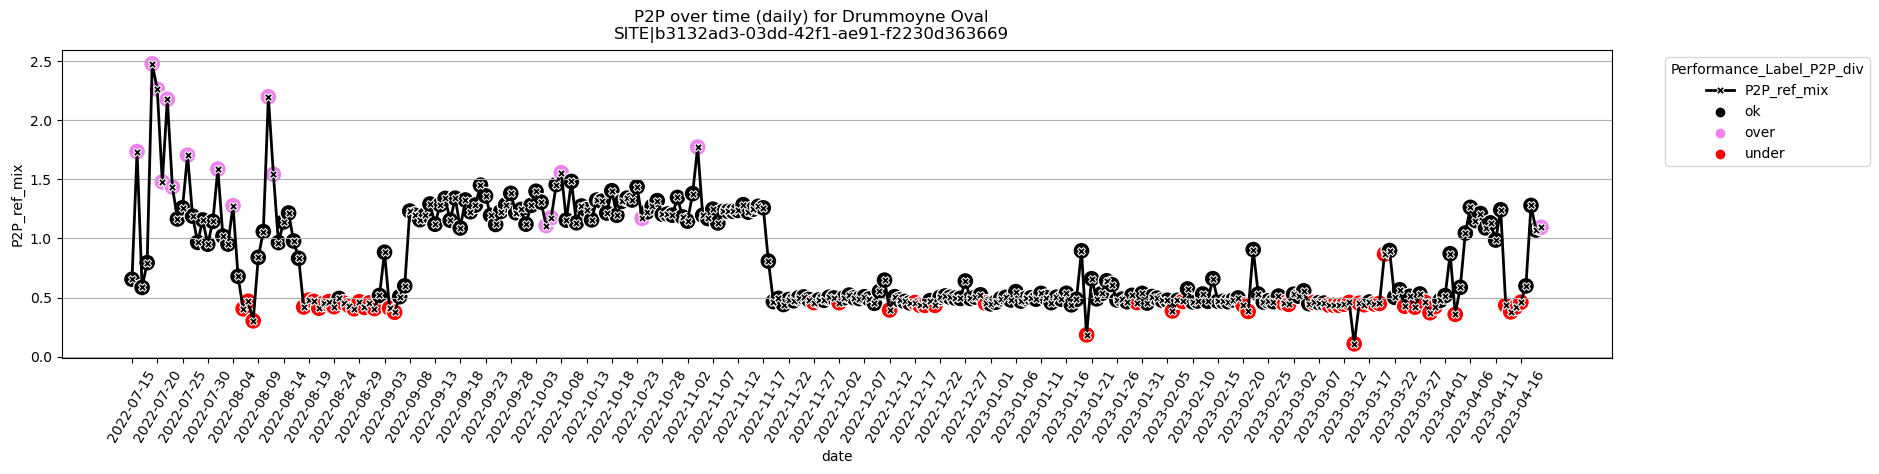

In [221]:
def plt_p2p_check(df, indicator):
    fig, ax1 = plt.subplots(nrows=1,figsize=(20, 4))
    plt.xticks(rotation=60)
    palette ={"ok": "black", "under": "red", "over": "violet", "medium": "darkorange"}
    sns.lineplot(data = df, x='date', y=indicator, marker='X', color='black', ax=ax1, 
                 label=indicator, lw=2)
    sns.scatterplot(data = df, x='date', y=indicator, hue='Performance_Label_P2P_div',
                    palette=palette, markers='X', s=150, ax=ax1)
    fig.suptitle('P2P over time (daily) for ' + str(site_name) + '\n' + str(focus_site_id_full))
    sns.move_legend(ax1, "upper left", bbox_to_anchor=(1.03, 1))
    ticks, labels = plt.xticks()
    plt.xticks(ticks[::5], labels[::5])
    ax1.grid(axis='y')
    # figname = str(site_id + '.png')
    # fig.savefig('./plots/' + figname)
plt_p2p_check(df_p2p_pr, indicator='P2P_ref_mix')

In [205]:
df_pvmeasure

date  Production.kWh.Daily  Irrad.kWh.m2.Daily  \
0    2022-07-15            103.164083          133.029428   
1    2022-07-16            104.527250          109.966491   
2    2022-07-17             93.385417          135.359410   
3    2022-07-18            129.837500          135.830289   
4    2022-07-19            138.444167           84.438051   
..          ...                   ...                 ...   
275  2023-04-16             29.702583           86.598424   
276  2023-04-17             51.547250          120.904264   
277  2023-04-18            113.984250          147.905811   
278  2023-04-19            140.763583          161.669772   
279  2023-04-20             33.059083           47.717389   

     EnergyYield.kWh.Daily  expected_over_clear is_low_cloudiness_day  \
0               134.859982            98.642626                  True   
1               135.522351            81.142697                  True   
2               136.185238            99.393599                  True   
3               136.874952            99.236776                  True   
4               137.592791            61.368078                 False   
..                     ...                  ...                   ...   
275             185.506414            46.682172                 False   
276             183.997744            65.709645                 False   
277             182.497231            81.045510                  True   
278             181.004316            89.318186                  True   
279             179.519691            26.580588                 False   

     Performance_Ratio(%).Daily performancelabel_pr  
0                     77.549821              medium  
1                     95.053729                  ok  
2                     68.990709              medium  
3                     95.588032                  ok  
4                    163.959453                  ok  
..                          ...                 ...  
275                   34.299219               under  
276                   42.634766               under  
277                   77.065431              medium  
278                   87.068585                  ok  
279                   69.280997              medium  

[280 rows x 8 columns]

In [206]:
df_power_fig = df_pvmeasure.copy()
df_power_fig.reset_index(inplace=True)

In [209]:
# plot for conference paper

def plt_p2p_pr(df_p2p, df_cuf, df_power, topsite_list, reference_MID, p2p_method):
    palette ={"ok": "black", "under": "red", "over": "violet", "medium": "darkorange"}
    fig, axes = plt.subplots(nrows=3, figsize=(26, 18))
    plt.xticks(rotation=90)
    matplotlib.rc_file_defaults()

    sns.lineplot(data = df_power[measure_name_actual], marker='o', sort = False, ax=axes[0], 
                       label = 'Actual Production', linewidth=3, markersize=10, color='black')
    axes[0].set_ylabel('Daily AC Generation (KWh)', fontsize=24)
    axes[0].legend(loc=2, fontsize=24)
    axes[0].set_xticks([])
    axes[0].tick_params(axis='both', labelsize=24)
    axes11 = axes[0].twinx()
    sns.barplot(data=df_power, x='date', y='expected_over_clear', alpha=0.3, ax=axes11, hue='is_low_cloudiness_day',
                      palette={False: "purple", True: "grey"}, width=1.1)
    
    axes11.tick_params(axis='both', labelsize=24)
    axes11.legend(loc=1, fontsize=24)
    # axes11.set_xticks([])
    axes11.set_ylabel('Clear Sky', fontsize=24)
    axes11.tick_params(axis='both', labelsize=24)
    axes[0].grid(axis='y')

    ## cuf
    for j, site_id in enumerate(topsite_list):
        if j<=8:
            axes[1].plot(df_cuf['date'], df_cuf[site_id], '-o', label='CUF Peer {}'.format(j))
    axes[1].plot(df_cuf['date'], df_cuf['Focus_PV'], '-o', color='blue', label='CUF Focus PV', lw=2.5)
    axes[1].plot(df_cuf['date'], df_cuf[reference_MID], '-o', color='red', label='Ref. CUF PV', lw=2.5)
    axes[1].legend(fontsize=22)
    axes[1].grid(axis='y')
    axes[1].tick_params(axis='both', labelsize=28)
    axes[1].set_ylabel('CUF', fontsize=28)
    axes[1].set_xticks([])

    # p2p
    axes[2].plot(df_p2p['date'].values, np.ones(len(df_p2p))*0.8, '--', color='darkred', label='Medium Threshold')
    axes[2].fill_between(df_p2p['date'].values, y1=1.5, y2=0.8, color='grey')
    axes[2].plot(df_p2p['date'].values, np.ones(len(df_p2p))*0.6, '--', color='red', label='Under Threshold')
    axes[2].fill_between(df_p2p['date'].values, y1=0.8, y2=np.ones(len(df_p2p))*0.6, color='lightgrey')
    axes[2].plot(df_p2p['date'].values, df_p2p['P2P_ref_{}'.format(p2p_method)].values, '-^', color='black', label=' P2P Reference {}'.format(p2p_method))
    sns.scatterplot(data = df_p2p, x='date', y='P2P_ref_{}'.format(p2p_method), hue='Perfomrnace_P2P_constant_{}'.format(p2p_method), 
                    palette=palette, markers='o', s=160, ax=axes[2])
    axes[2].legend(fontsize=18)
    axes[2].set_xlabel('Date (Daily Data)', fontsize=28)
    axes[2].set_ylabel('P2P/Threshold', fontsize=28)
    axes[2].tick_params(axis='both',  labelsize=28)

    for i in range(2):
        axes[i].set_xlim(-1, len(df_p2p) + 1)
        # axes[i].tick_params(axis='both', labelsize=14)
        # if i in [1]:
        #     axes[i].set_xticks(axes[i].get_xticks()[::10])
        #     for label in axes[i].get_xticklabels():
        #         label.set_rotation(90)
        # else:
        axes[i].set_xticks([])
    axes[2].set_xlim(-1, len(df_p2p) + 1)
    axes[2].set_xticks(axes[2].get_xticks()[::10])
    fig.tight_layout()
    plt.savefig('p2p_long_term.pdf')

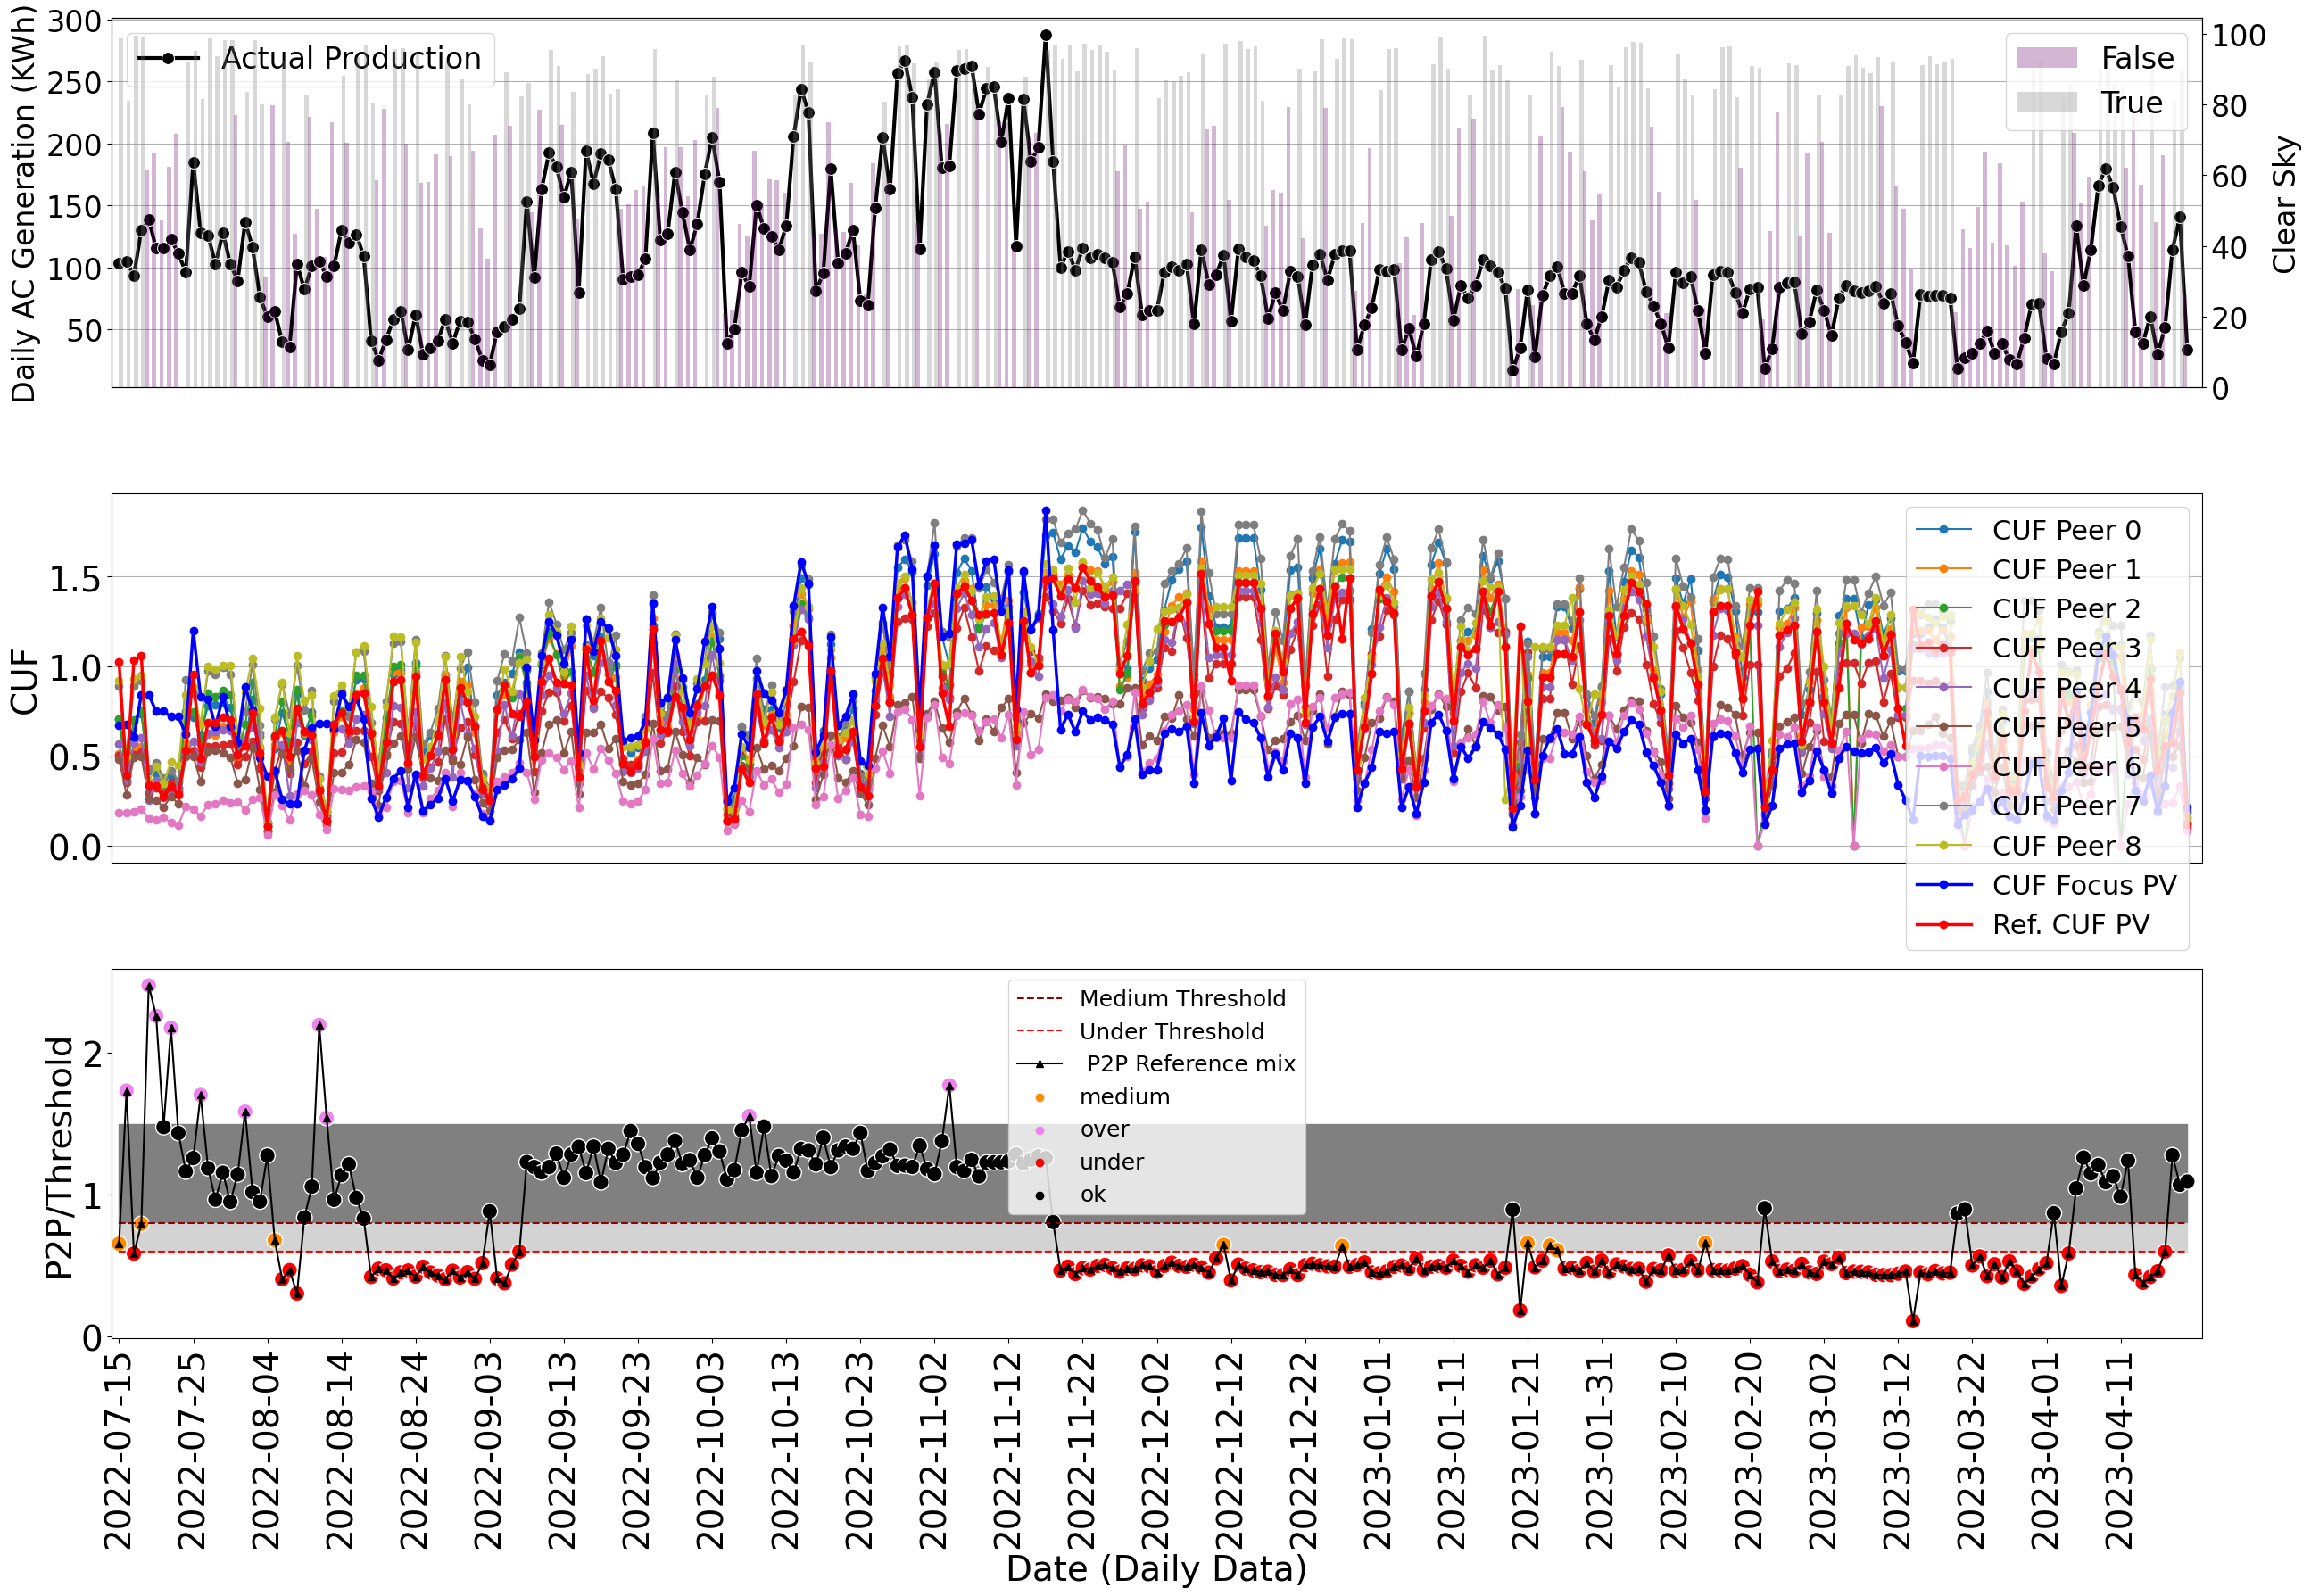

In [210]:
plt_p2p_pr(df_p2p=df_p2p_pr, df_cuf=df_cuf, df_power=df_power_fig, reference_MID='ref_cuf', 
           topsite_list=effective_peers_window_list, 
           p2p_method='mix')